<div class="alert alert-block alert-info"> <h1> Project: Semantic Role Labeling with Conditional Random Fields <h1> </div> 

**Author: Don Piumsuwan**

**Github: https://github.com/DontrP**

**LinkedIn: https://www.linkedin.com/in/dollaya-piumsuwan/**

**Portfolios: https://www.datascienceportfol.io/dollayap**

In [14]:
"""
Import libraries
"""


import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import sklearn_crfsuite
import seaborn as sns
import networkx as nx
import json

from itertools import chain
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import metrics
from sklearn_crfsuite.utils import flatten
from sklearn import metrics as skmetrics
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter


<div class="alert alert-block alert-warning"> <h2> Introduction <h3> </div>

This project focuses on Semantic Role Labeling (SRL), which aims to identify 'semantic roles of each argument of each predicate in the sentence' (Jurafsky and Martin, 2020, p. 468). Based on linguistic perspective, determining semantic roles of each argument require a holistic view of language level and structure (see Figure 1). For instance, syntactic relationships (syntax) between subjects, objects, and verbs, plays significant roles in determining role of word in the sentence. Active voice of 'agree' can be proceeded with *'ARG0'* (PROTO-AGENT)or a doer of the action, while it can be followed by *'ARG1'* (PROTO-PATIENT) or object of the action (Jurafsky and Martin, 2020, p. 465). Most importantly, the semantic role is usually governed by the 'governing predicate' or the root verb of the sentence. In some cases where sent is only a word, clause, or phrase, governing predicate can be a noun or be absent. The focus of this task will be on understanding the relationship of words in the sentence.

In this task, I begin with examining the CoNLL-U files through visual and non-visual exploratory data analysis. Then, I extract the relevant features based on linguistic understanding and best practices from literatures. After that, I develop the baseline model without hyperparameter tuning and examined the model performance. Then, I proceed to development the model with hyperparameter tuning before generate the predictions on the test dataset.

![lang_comp](data/levelsoflanguage-graph.gif.html){width=400}

*Figure 1: Overview of Levels of Language Complexity.* Source: [Overview of semantics in Linguistics. (2014, July 24). Veryserioso.](https://veryserioso.wordpress.com/semantics/overview-of-semantics-in-linguistics/)


**References:**

Overview of semantics in Linguistics. (2014, July 24). Veryserioso. https://veryserioso.wordpress.com/semantics/overview-of-semantics-in-linguistics/

<div class="alert alert-block alert-warning"> <h2> 1. Parsing and Explore the Datasets <h3> </div>

<div class="alert alert-block alert-success"> <h3> 1.1 Parsing the Data <h3> </div>

Initially I parse the data the CoNLL-U train, dev, and test files, ensuring that all sentences have 12 columns by substitute missing columns with '_' for those with less than 12 columns. This is because the task requires 12 columns according to the task specification, but the CoNLL-U format contains annotation of node in 10 fields (CoNLL-U Format, n.d.).

It is noted that I exclude the empty nodes, marked with float ID such as 24.1. According to CoNLL-U Format (n.d.), these are empty nodes. They often serve syntactic structure rather than semantic roles according to Universal Dependencies (2014) (see Figure 2). Adding empty nodes to the semantic role labelling task can complicate the dependency structure.  

![empty_node](data/empty_node.png){width=500}

*Figure 2: UD Enhanced Representation.* Source: [Zeman, D. (2021). Enhanced Universal Dependencies NPFL075 Dependency Grammars and Treebanks.](https://ufal.mff.cuni.cz/~zeman/vyuka/deptreebanks/ud3-enhanced-syntax.pdf‌)

**References:**

CONLL-U format. (n.d.). https://universaldependencies.org/format.html#extensions
‌
Universal Dependencies. (2014). Github.io. https://fginter.github.io/docs/u/dep/all.html

Zeman, D. (2021). Enhanced Universal Dependencies NPFL075 Dependency Grammars and Treebanks.](https://ufal.mff.cuni.cz/~zeman/vyuka/deptreebanks/ud3-enhanced-syntax.pdf


In [15]:
"""
Define function to parse the dataset
"""

def parse_conllu(file_path):
    
    sentences = []
    sentence = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('#') or line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split('\t')
                
                # Fill token with less than 12 columns with underscore
                if len(parts) < 12:
                    parts.extend(['_'] * (12 - len(parts)))

                # Extract the elements
                token_id = parts[0]
                form = parts[1]
                lemma = parts[2]
                upos = parts[3]
                xpos = parts[4]
                grammar_feats = parts[5]
                head = parts[6]
                deprel = parts[7]  
                deps = parts[8]
                misc = parts[9]
                predicate = parts[10]
                argument_label = parts[11]
                
                sentence.append((token_id, form, lemma, upos, xpos, grammar_feats, head, deprel, deps, misc, predicate, argument_label))
                
    if sentence:
        sentences.append(sentence)
    return sentences


In [16]:
"""
Parse the dataset
"""

train = parse_conllu('data/en_ewt-up-train.conllu')
dev = parse_conllu('data/en_ewt-up-dev.conllu')
test = parse_conllu('data/en_ewt-up-test-no-labels.conllu')

# Check train dataset
print(f'Train Data:')
print(train[0])

# Check dev
print(f'\nDev Data:')
print(dev[5])

# Check test 
print(f'\nTest Data:')
print(test[2])

Train Data:
[('1', 'Al', 'Al', 'PROPN', 'NNP', 'Number=Sing', '0', 'root', '0:root', 'SpaceAfter=No', '_', '_'), ('2', '-', '-', 'PUNCT', 'HYPH', '_', '1', 'punct', '1:punct', 'SpaceAfter=No', '_', '_'), ('3', 'Zaman', 'Zaman', 'PROPN', 'NNP', 'Number=Sing', '1', 'flat', '1:flat', '_', '_', '_'), ('4', ':', ':', 'PUNCT', ':', '_', '1', 'punct', '1:punct', '_', '_', '_'), ('5', 'American', 'american', 'ADJ', 'JJ', 'Degree=Pos', '6', 'amod', '6:amod', '_', '_', '_'), ('6', 'forces', 'force', 'NOUN', 'NNS', 'Number=Plur', '7', 'nsubj', '7:nsubj', '_', '_', 'ARG0'), ('7', 'killed', 'kill', 'VERB', 'VBD', 'Mood=Ind|Tense=Past|VerbForm=Fin', '1', 'parataxis', '1:parataxis', '_', 'kill.01', 'V'), ('8', 'Shaikh', 'Shaikh', 'PROPN', 'NNP', 'Number=Sing', '7', 'obj', '7:obj', '_', '_', 'ARG1'), ('9', 'Abdullah', 'Abdullah', 'PROPN', 'NNP', 'Number=Sing', '8', 'flat', '8:flat', '_', '_', '_'), ('10', 'al', 'al', 'PROPN', 'NNP', 'Number=Sing', '8', 'flat', '8:flat', 'SpaceAfter=No', '_', '_'), ('1

In [17]:
"""
Check empty nodes (Float IDs)
"""

def show_empty_node(data, file_name):
    print(f'\nEmpty nodes in {file_name}: ')
    for sentence in data:
        for token in sentence:
            if '.' in token[0]:
                print(token)

show_empty_node(train, 'train data')
show_empty_node(dev, 'dev data')
show_empty_node(test, 'test data')


Empty nodes in train data: 
('8.1', 'reported', 'report', 'VERB', 'VBN', 'Tense=Past|VerbForm=Part|Voice=Pass', '_', '_', '5:conj:and', 'CopyOf=5', '_', '_')
('22.1', 'used', 'use', 'VERB', 'VBN', 'Tense=Past|VerbForm=Part', '_', '_', '13:advcl:with|17:conj:and', 'CopyOf=17', '_', '_')
('22.1', 'used', 'use', 'VERB', 'VBN', 'Tense=Past|VerbForm=Part', '_', '_', '13:advcl:with|17:conj:and', 'CopyOf=17', '_', '_')
('11.1', 'called', 'call', 'VERB', 'VBN', 'Tense=Past|VerbForm=Part|Voice=Pass', '_', '_', '3:conj:and', 'CopyOf=3', '_', '_')
('14.1', 'is', 'be', 'VERB', 'VBZ', '_', '_', '_', '1:conj:and', 'CopyOf=1', '_', '_')
('5.1', 'taken', 'take', 'VERB', 'VBN', 'Tense=Past|VerbForm=Part', '_', '_', '0:root', 'CopyOf=9', '_', '_')
('20.1', 'reflect', 'reflect', 'VERB', 'VBP', 'Mood=Ind|Tense=Pres|VerbForm=Fin', '_', '_', '7:acl:relcl|9:conj', 'CopyOf=9', '_', '_')
('21.1', 'recruited', 'recruit', 'VERB', 'VBD', 'Mood=Ind|Tense=Past|VerbForm=Fin', '_', '_', '9:conj:and', 'CopyOf=9', '_'

In [18]:
"""
Drop tokens with float ID (empty nodes) and check the data
"""

def drop_empty_node(sentences):
    return [[token for token in sentence if '.' not in token[0]] for sentence in sentences]

# Apply the filter function to each dataset
train_data = drop_empty_node(train)
dev_data = drop_empty_node(dev)
test_data = drop_empty_node(test)

# Check the filtered data
print("Filtered Train Data:")
print(train_data[0])

print("\nFiltered Dev Data:")
print(dev_data[5])

print("\nFiltered Test Data:")
print(test_data[2])

show_empty_node(train_data, 'train data')
show_empty_node(dev_data, 'dev data')
show_empty_node(test_data, 'test data')


Filtered Train Data:
[('1', 'Al', 'Al', 'PROPN', 'NNP', 'Number=Sing', '0', 'root', '0:root', 'SpaceAfter=No', '_', '_'), ('2', '-', '-', 'PUNCT', 'HYPH', '_', '1', 'punct', '1:punct', 'SpaceAfter=No', '_', '_'), ('3', 'Zaman', 'Zaman', 'PROPN', 'NNP', 'Number=Sing', '1', 'flat', '1:flat', '_', '_', '_'), ('4', ':', ':', 'PUNCT', ':', '_', '1', 'punct', '1:punct', '_', '_', '_'), ('5', 'American', 'american', 'ADJ', 'JJ', 'Degree=Pos', '6', 'amod', '6:amod', '_', '_', '_'), ('6', 'forces', 'force', 'NOUN', 'NNS', 'Number=Plur', '7', 'nsubj', '7:nsubj', '_', '_', 'ARG0'), ('7', 'killed', 'kill', 'VERB', 'VBD', 'Mood=Ind|Tense=Past|VerbForm=Fin', '1', 'parataxis', '1:parataxis', '_', 'kill.01', 'V'), ('8', 'Shaikh', 'Shaikh', 'PROPN', 'NNP', 'Number=Sing', '7', 'obj', '7:obj', '_', '_', 'ARG1'), ('9', 'Abdullah', 'Abdullah', 'PROPN', 'NNP', 'Number=Sing', '8', 'flat', '8:flat', '_', '_', '_'), ('10', 'al', 'al', 'PROPN', 'NNP', 'Number=Sing', '8', 'flat', '8:flat', 'SpaceAfter=No', '_', 

<div class="alert alert-block alert-success"> <h3> 1.2 Data Exploratory Analysis (EDA) <h3> </div>

After parsing the files, there are 12543 sentences in train, 2002 sentences in dev, and 2077 sentence in test dataset. I investigate the frequency of labels in train and dev datasets. The most frequent label is the default label underscore ('_'). This indicate that most of the tokens do not contain argument labels. After filtering out the default label, I note that *'V'* is the most frequent semantic role, followed by *'ARG1'* and *'ARG0'*. The majority of labels have very low counts, indicating a significant imbalance in the argument label. Most importantly, I found that the discrepancy of labels in train and dev dataset, such that some label in train do not contain in dev dataset. 

Each attribute in the dataset also show high variability. For instance, predicate columns show high number of unique values. This is because it contain th predicate and its sense, divided by dot (Jurafsky and Martin, 2020). Most attributes also show significant skewness such predicate, grammatical features, and miscellaneous information. Each value in grammatical features and miscellaneous information also contain sub categories divided by '|'. 

It is noted that I decide not to use 'DEPS' columns as it is 'enhanced dependency graph in the form of a list of head-deprel pairs' (CONLL-U format, n.d.). It contains multiple relationships for a single token. Including this feature in the model requires advanced understanding of syntactic structure and can increase computational complexity. 


**References:**

CONLL-U format. (n.d.). https://universaldependencies.org/format.html#extensions

Jurafsky, D., & Martin, J. (2020). Speech and Language Processing An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition Third Edition draft. https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf

‌

Sentence in train: 12543
Sentence in dev: 2002
Sentence in test: 2077


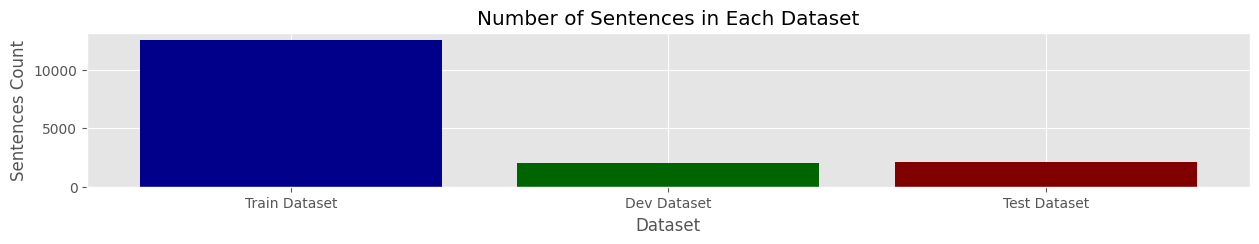

In [19]:
"""
Check number of sentences in the dataset.
"""

print(f'Sentence in train: {len(train_data)}')
print(f'Sentence in dev: {len(dev_data)}')
print(f'Sentence in test: {len(test_data)}')

x_axis= ['Train Dataset', 'Dev Dataset', 'Test Dataset']
all_token_counts = [len(train_data), len(dev_data), len(test_data)]

plt.figure(figsize=(15, 2))
plt.bar(x_axis, all_token_counts, color=['darkblue', 'darkgreen', 'maroon'])
plt.xlabel('Dataset')
plt.ylabel('Sentences Count')
plt.title('Number of Sentences in Each Dataset')
plt.show()


In [20]:
"""
Define function to explore attributes
"""

# Function to count valued of attributes
def count_value(sentences, index):
    value_counts = Counter()
    for sentence in sentences:
        for token in sentence:
            value_counts[token[index]] += 1
    return sorted(value_counts.items(), key=lambda item: item[1], reverse=True)

# Function for plot count
def plot_values_count(data, col_index, col_name):
    value_counts = count_value(data, col_index)
    labels, counts = zip(*value_counts)  # unpack tuple
    plt.figure(figsize=(35, 5))
    plt.bar(labels, counts, color='orange')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(col_name)
    plt.xticks(rotation=90)  
    plt.show()

# Function to filter out "_" 
def exclude_underscore(sentences, index):
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [token for token in sentence if token[index] != '_']
        if filtered_sentence: 
            filtered_sentences.append(filtered_sentence)
    return filtered_sentences
    

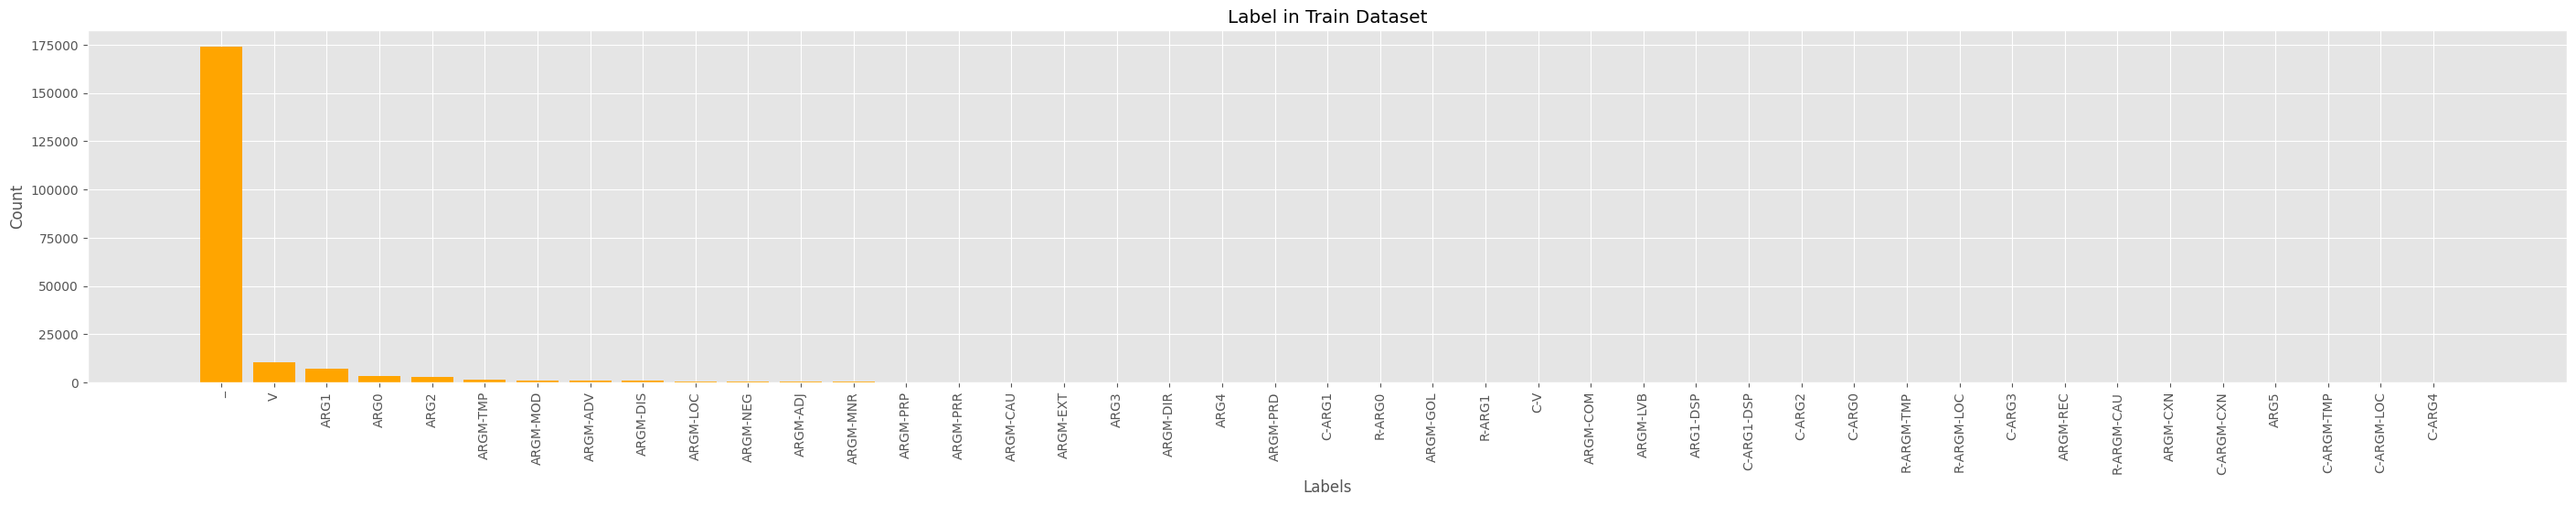

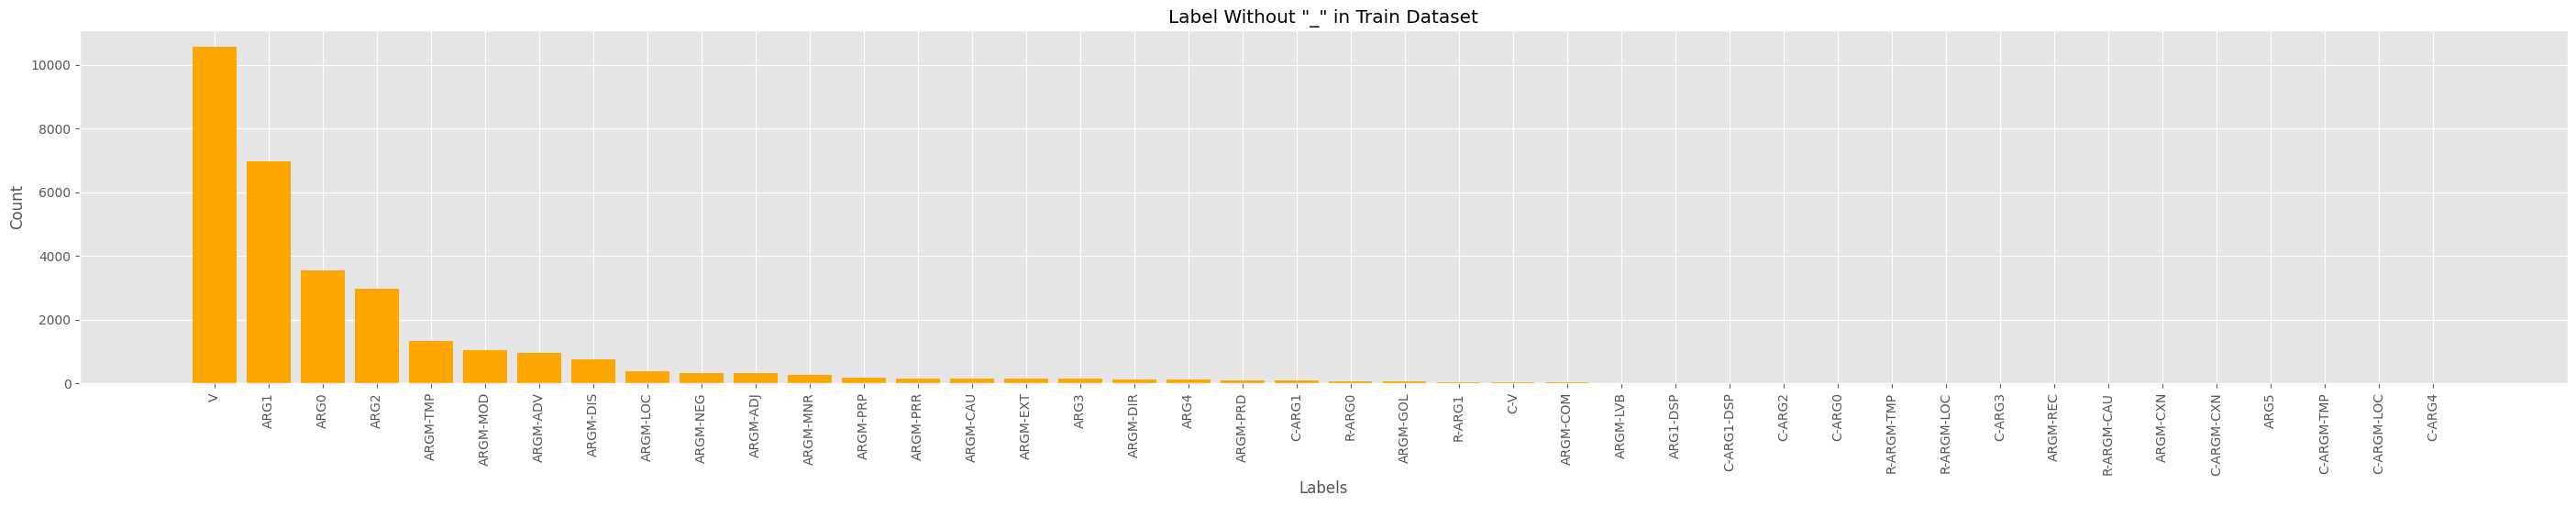

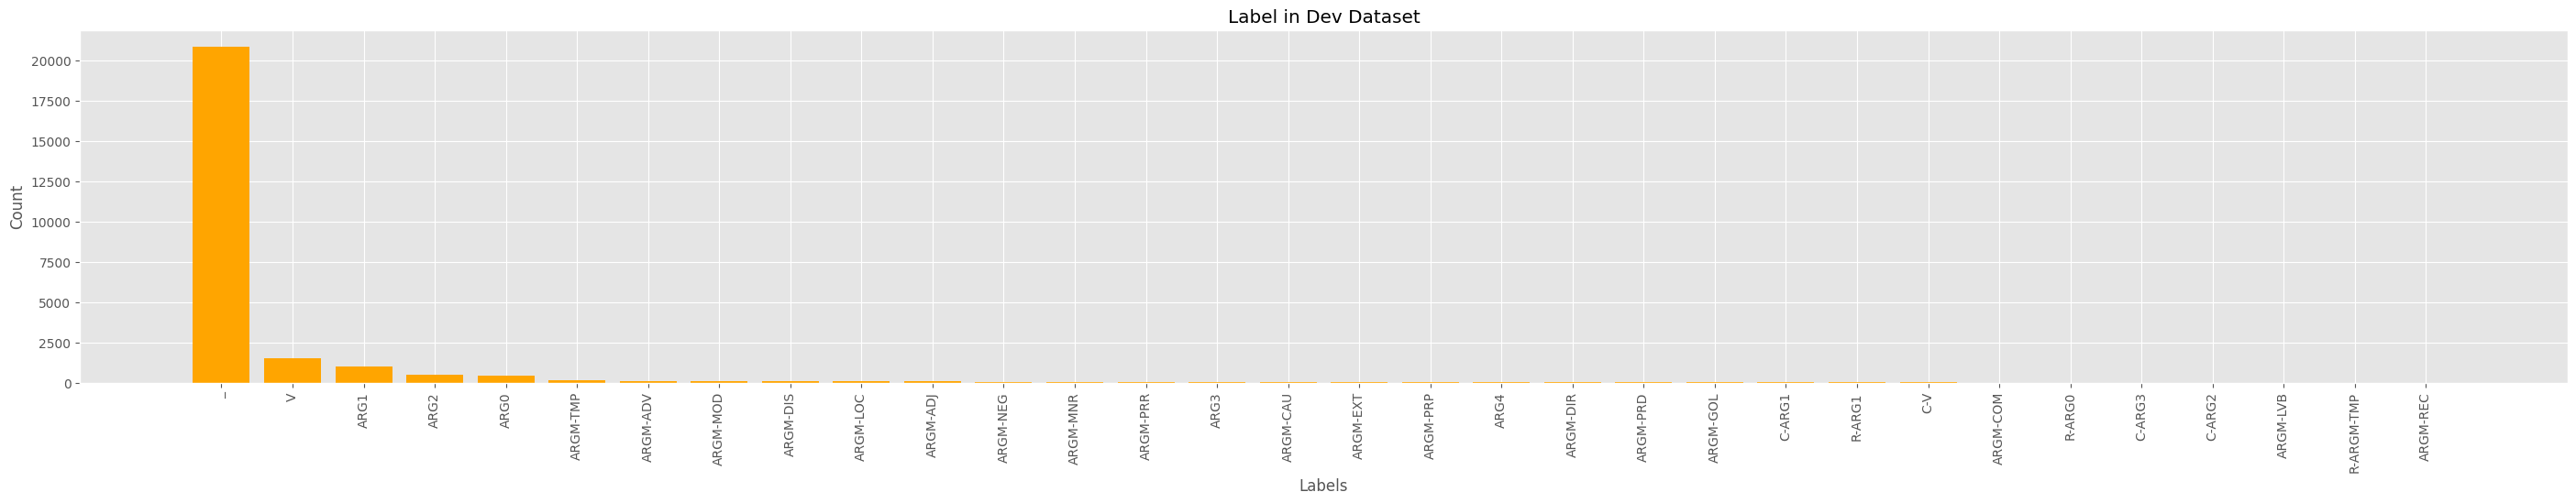

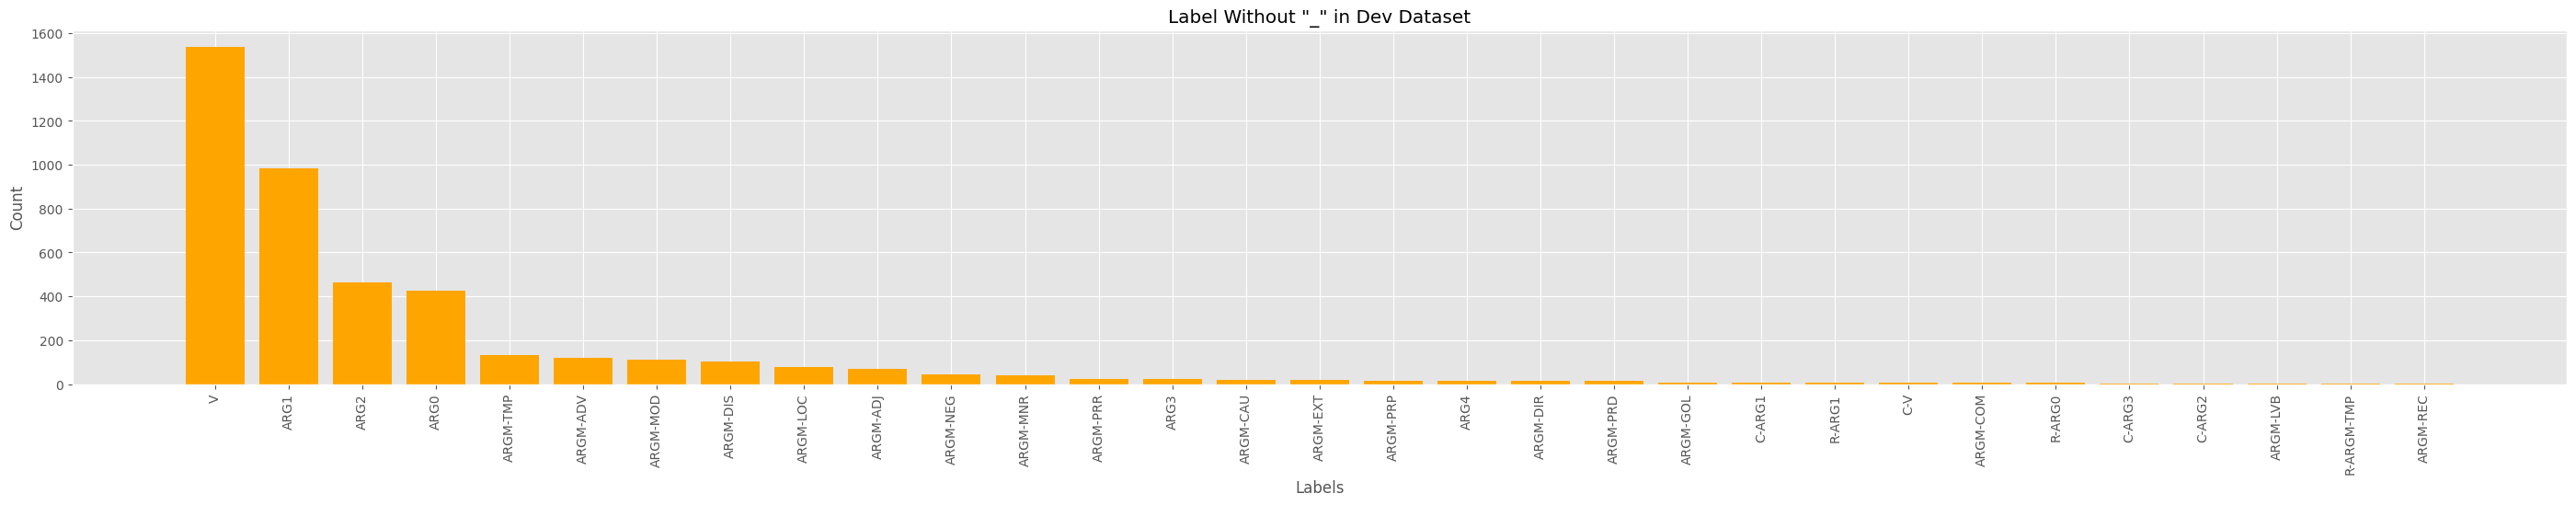

In [21]:
"""
Explore the labels in the dataset
"""

# Fitler out "_" label
train_label_filter = exclude_underscore(train_data, 11)
dev_label_filter = exclude_underscore(dev_data, 11)

plot_values_count(train_data, 11, 'Label in Train Dataset')
plot_values_count(train_label_filter, 11, 'Label Without "_" in Train Dataset')
plot_values_count(dev_data, 11, 'Label in Dev Dataset')
plot_values_count(dev_label_filter, 11, 'Label Without "_" in Dev Dataset')


In [22]:
"""
Check any discrepancies in labels between train and dev dataset
Some labels in train are not in dev
"""

# Count label
train_counts = count_value(train_data, 11)
dev_counts = count_value(dev_data, 11)

# Convert to dict to compare labels
train_label_dict = dict(train_counts)
dev_label_dict = dict(dev_counts)

# Identify unique label in each dataset
unique_train_labels = set(train_label_dict.keys()) - set(dev_label_dict.keys())
unique_dev_labels = set(dev_label_dict.keys()) - set(train_label_dict.keys())

# print
print('Labels unique to train dataset:')
for label in unique_train_labels:
    print(label)
print('\nLabels unique to dev dataset:')
for label in unique_dev_labels:
    print(label)


Labels unique to train dataset:
C-ARG1-DSP
C-ARGM-LOC
C-ARG4
R-ARGM-LOC
C-ARGM-CXN
C-ARG0
ARG1-DSP
R-ARGM-CAU
ARG5
ARGM-CXN
C-ARGM-TMP

Labels unique to dev dataset:


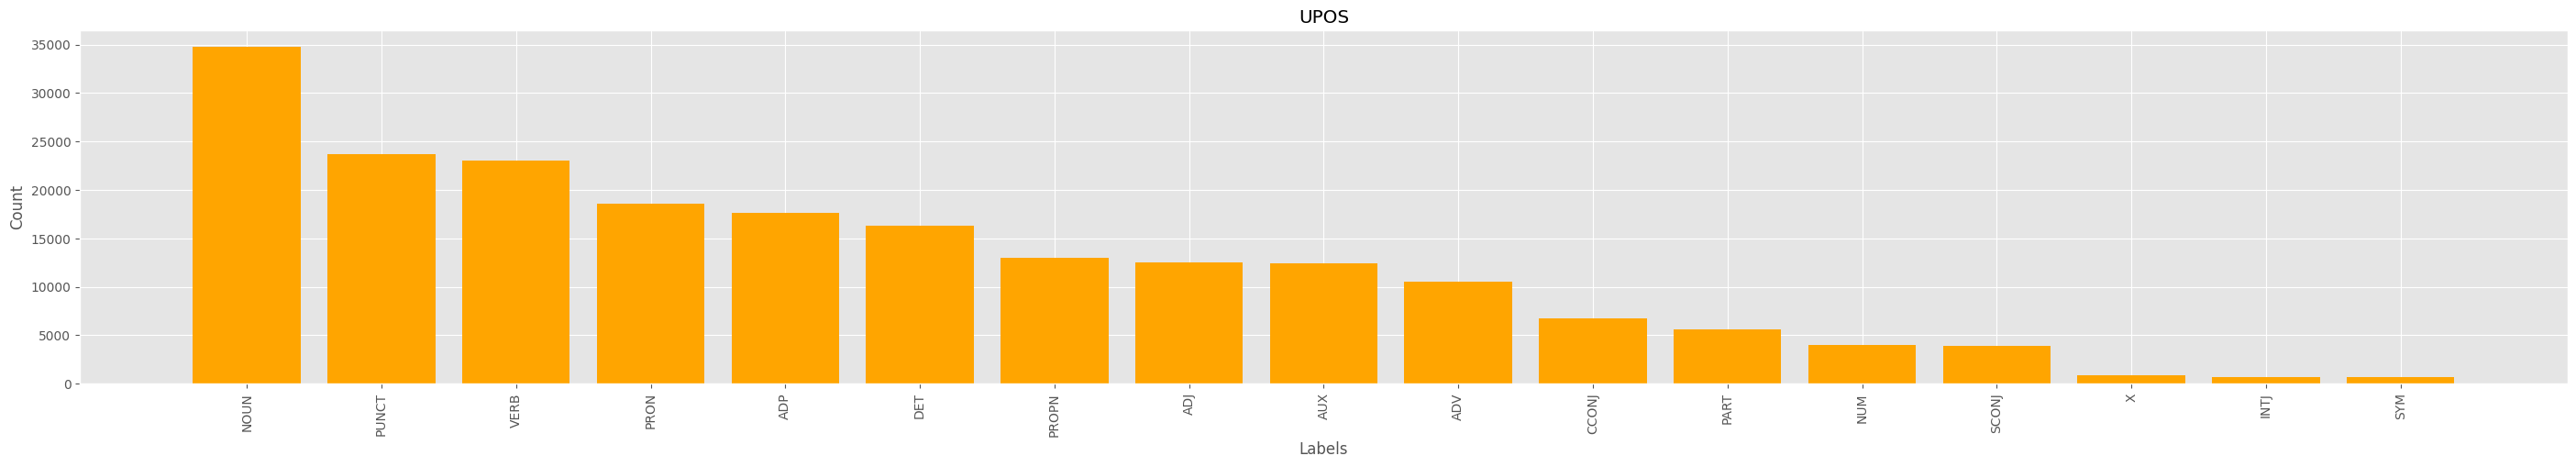

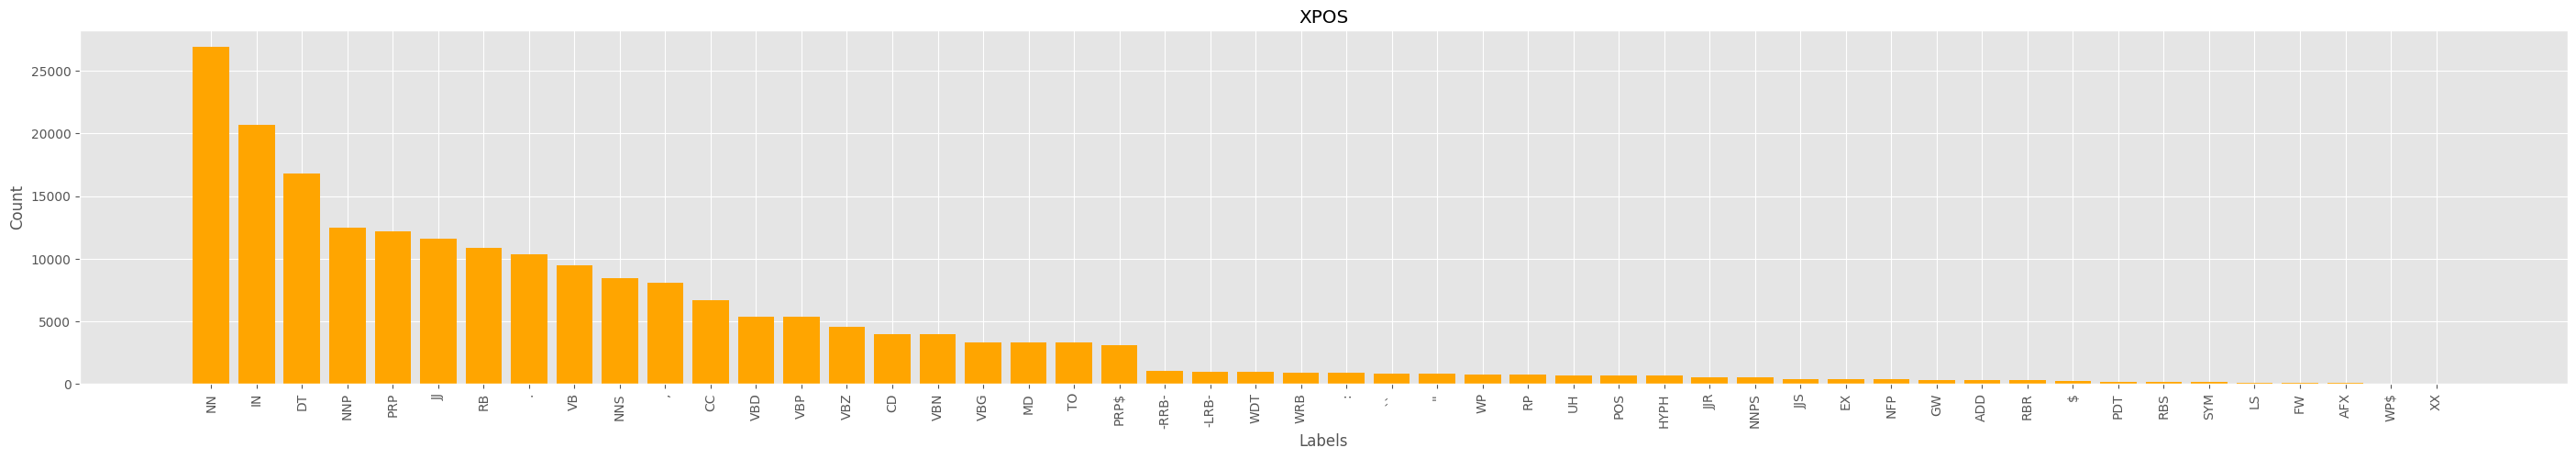

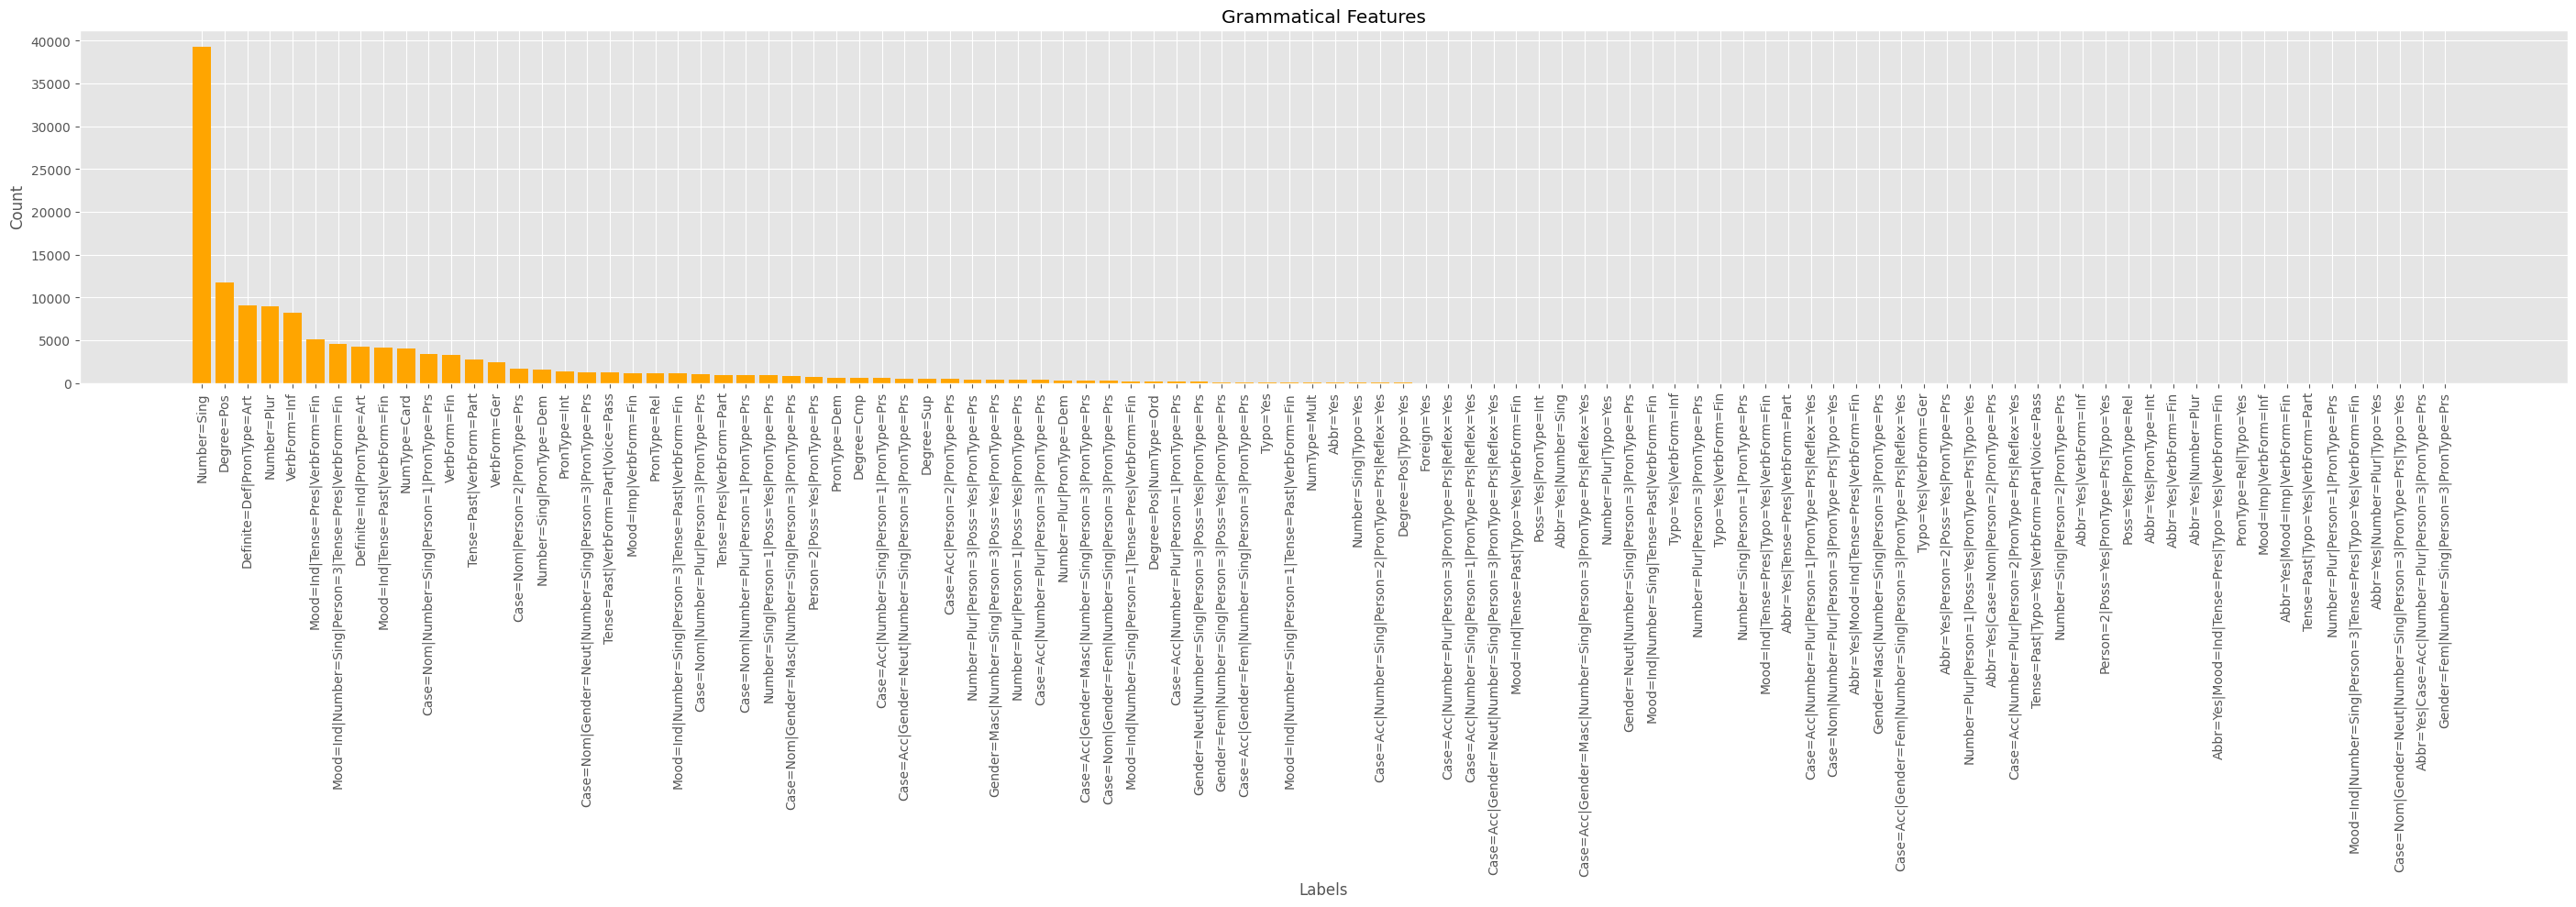

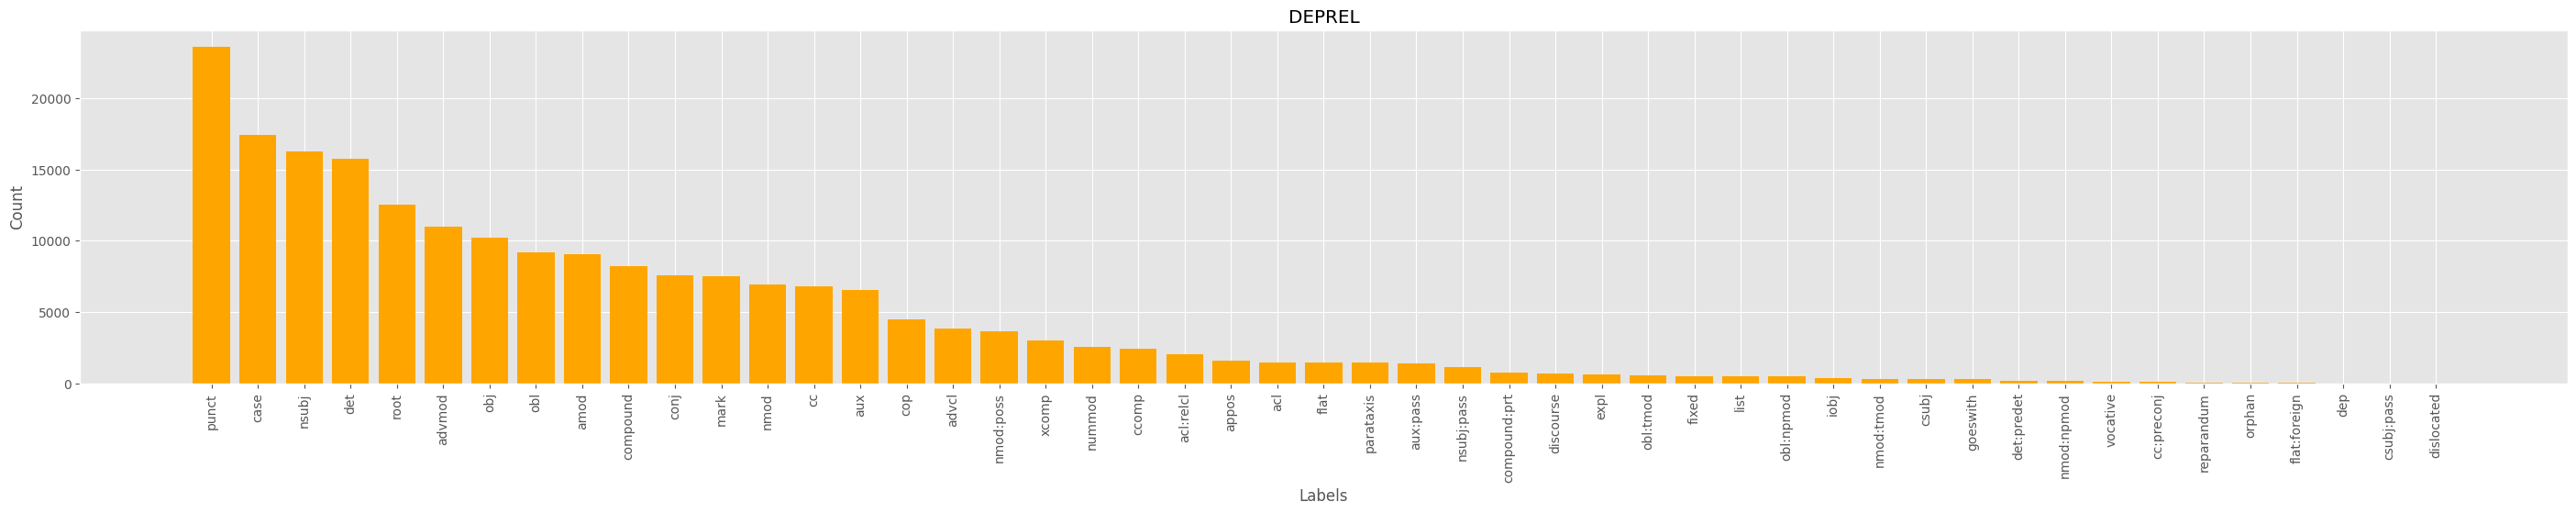

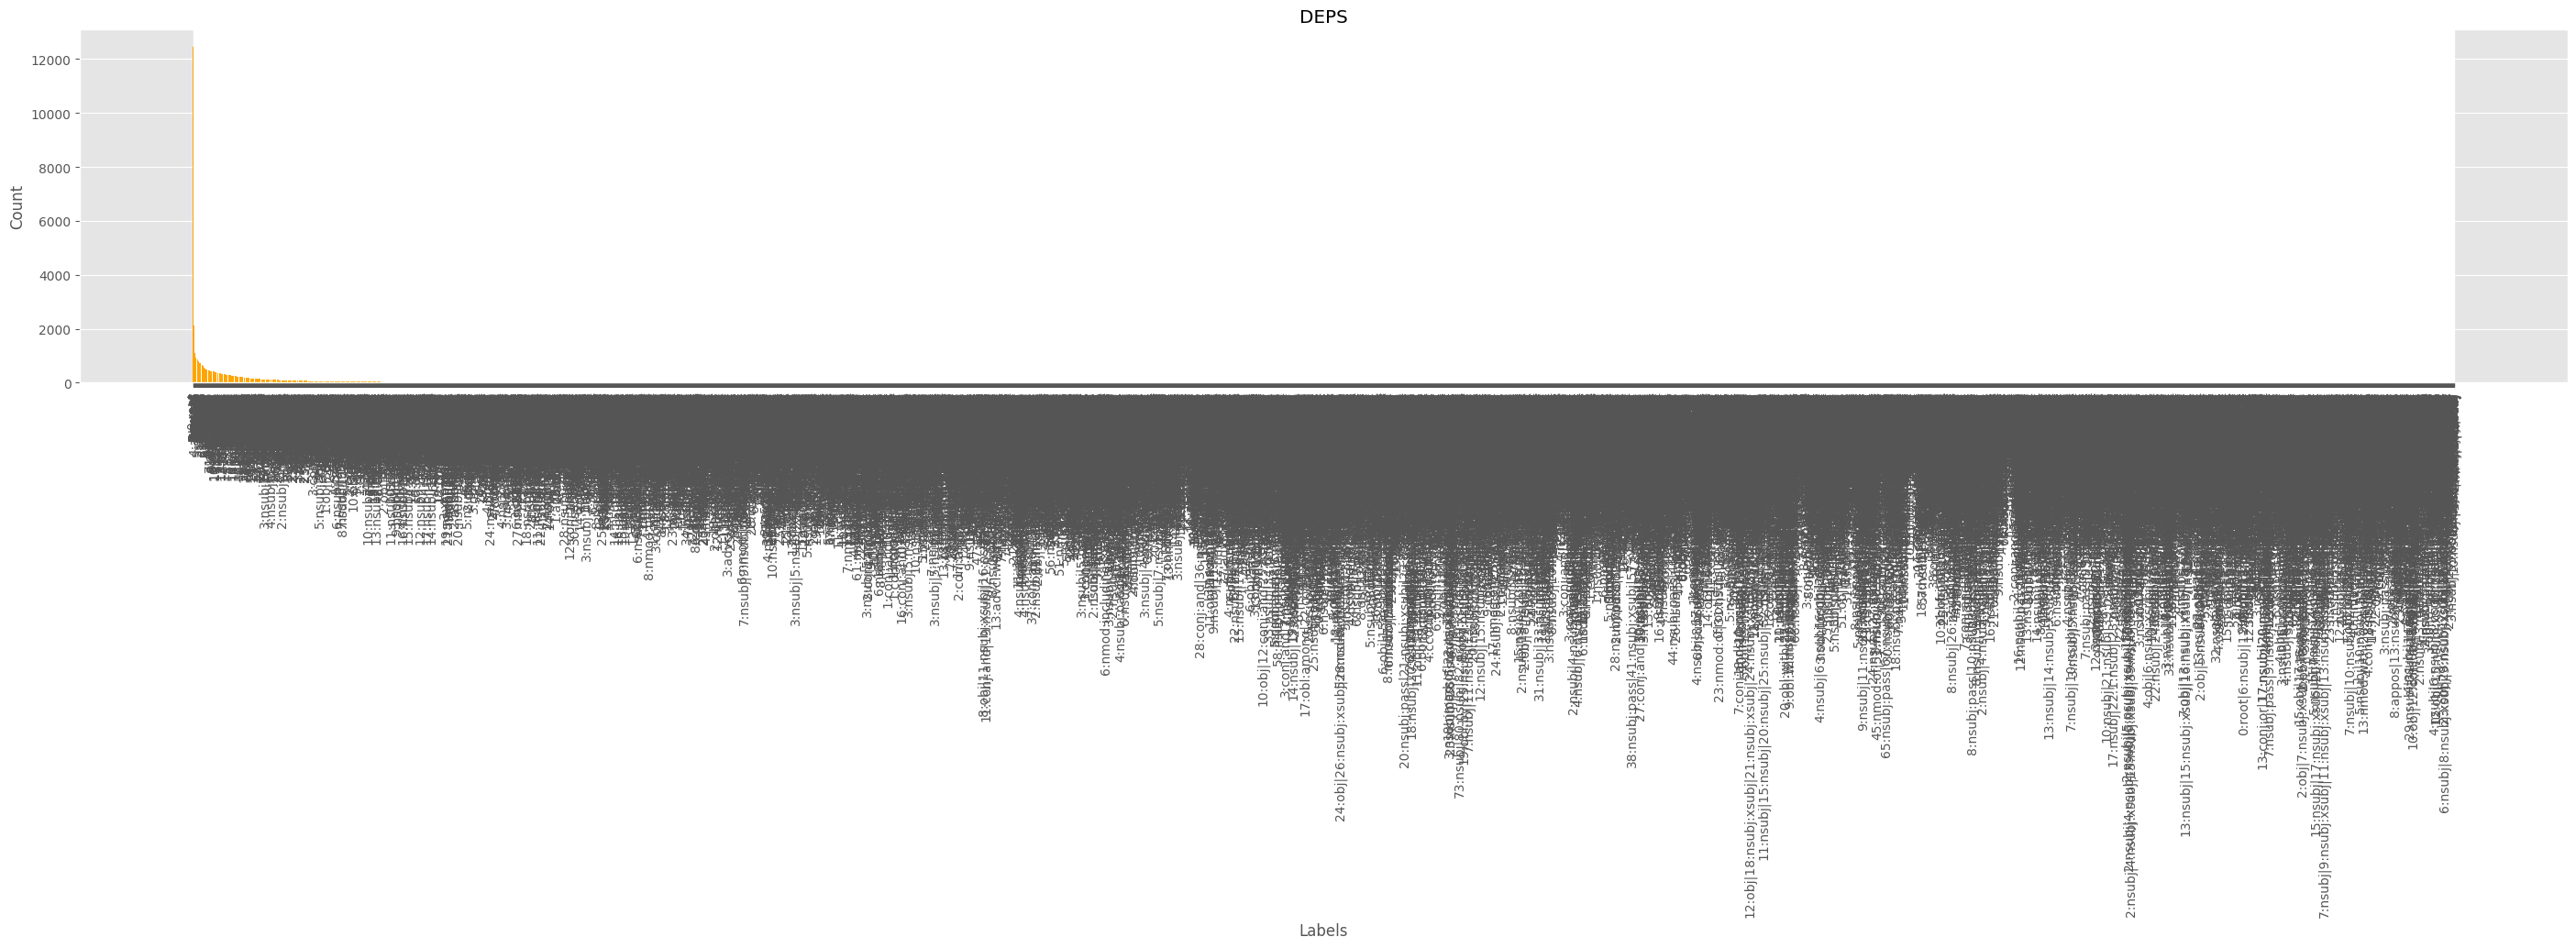

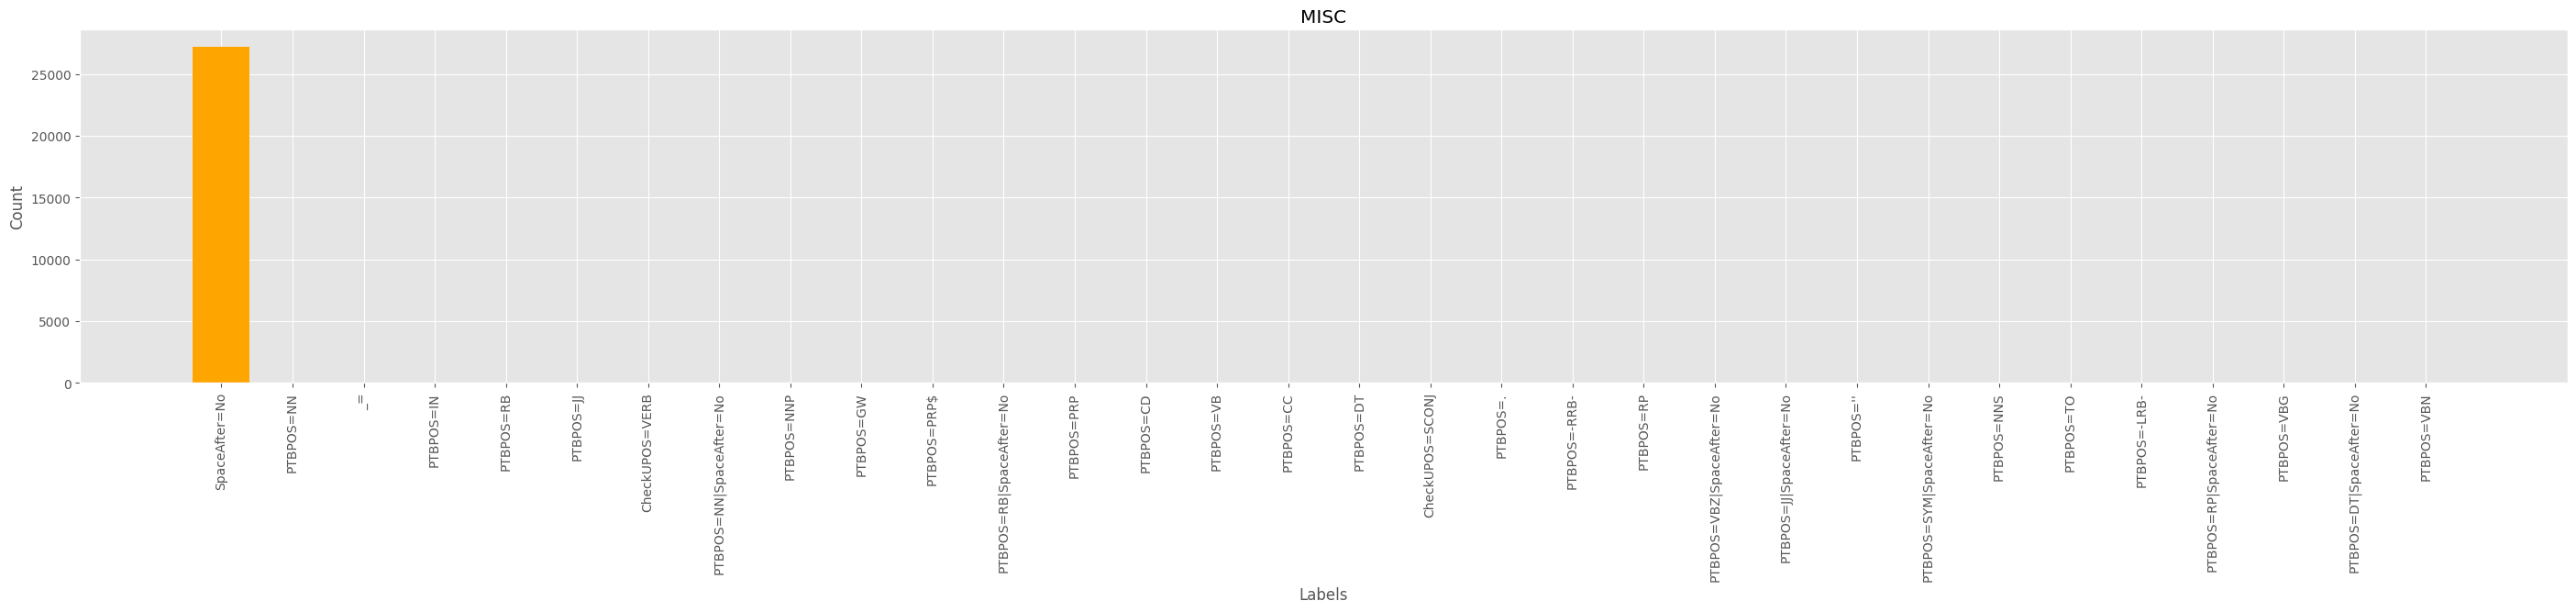

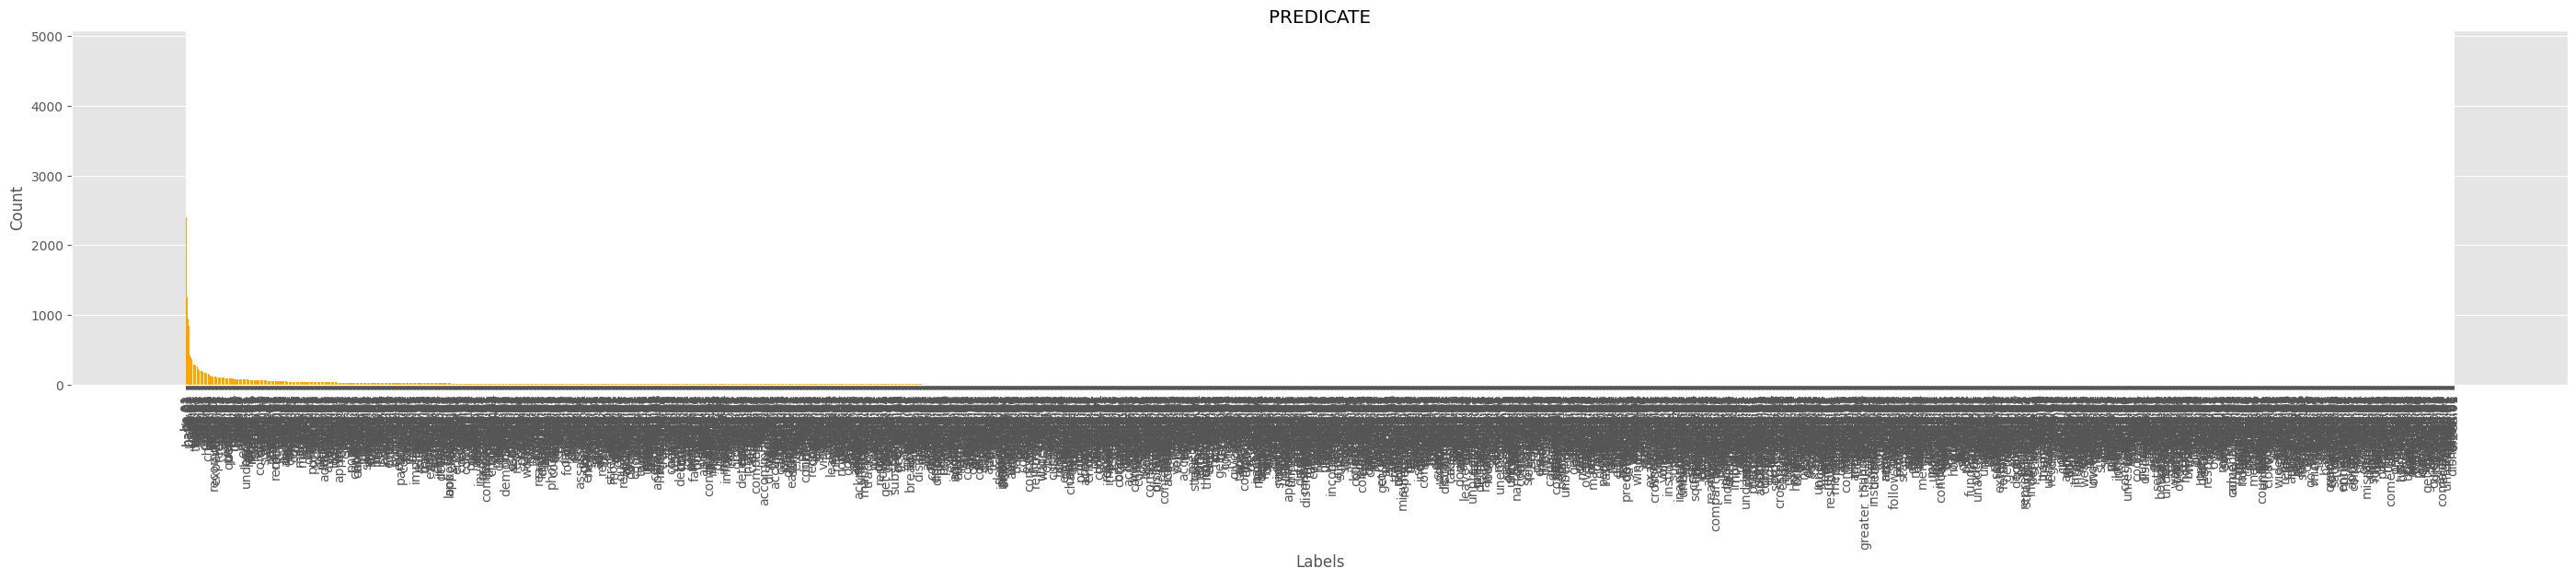

In [23]:
"""
Plot the rest of columns
"""

# UPOS
plot_values_count(train_data, 3, 'UPOS')

# XPOS
plot_values_count(train_data, 4, 'XPOS')

# Gram Feats
train_gram_filter = exclude_underscore(train_data, 5)
plot_values_count(train_gram_filter, 5, 'Grammatical Features')

# DEPREL
plot_values_count(train_data, 7, 'DEPREL')

# DEPS
plot_values_count(train_data, 8, 'DEPS')

# MISC
train_misc_filter = exclude_underscore(train_data, 9)
plot_values_count(train_misc_filter, 9, 'MISC')

# predicate
train_pred_filter = exclude_underscore(train_data, 10)
plot_values_count(train_pred_filter, 10, 'PREDICATE')

<div class="alert alert-block alert-success"> <h3> 1.3 Visualise Syntactic Dependencies <h3> </div>


To understand the syntactic relationship of token in the sentence (or phrase/clause), I visualise the dependency between tokens using network graph on sample sentence from the data. In the graph, each node represents a word, connected through edges that define their syntactic relationship. The arrows point from parent nodes to the child nodes, which indicate the influence of one token on others it points to. 

For concrete illustration, I visualise one sentence from the train set: 'If someone committed a crime against humanity, prosecute the person.'. It is a complete sentence with the VERB 'prosecute' as governing predicate and root of the sentence. It also influence the role of other tokens in the sentence (Jurafsky and Martin, 2020). 

However, take the noun phrase - 'CHERNOBYL ACCIDENT: TEN YEARS ON'. As it is merely a noun phrase, it does not have the VERB as governing predicate. In this case, the noun 'ACCIDENT' act as the root of the sentence and influence other tokens in the sentence.

In [24]:
"""
Function to visualise dependencies based on head using graph network
"""

# Function to create graph 
def create_graph(sentence):
    sent_g = nx.DiGraph()

    # Get the root of the sentence (from deprel)
    root_ids = set()
    for token in sentence: 
        if token[6] == '0':
            root_ids.add(token[0])  # if it is root get the id
            
    # Use id node, labelled with word form
    for token in sentence:
        sent_g.add_node(token[0], label=token[1]) 
        
    # Add edges, point out from root
    for token in sentence:
        # Get the parent id
        head_id = token[6]
        # Link edge from parent to token
        if token[6].isdigit() and token[0] not in root_ids and head_id != '0': 
            sent_g.add_edge(head_id, token[0])
            
    return sent_g


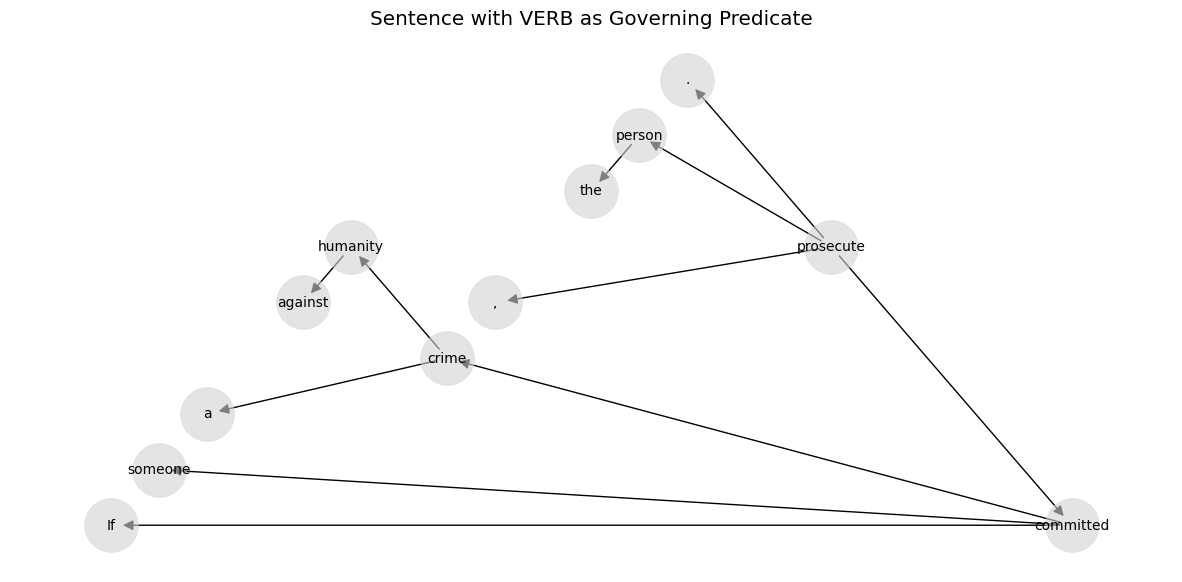

In [25]:
"""
Graph of sentence with verb as predicate
"""

# Create graph from sample sentence
sent_g = create_graph(train_data[35])
pos = nx.planar_layout(sent_g) 
node_labels = nx.get_node_attributes(sent_g, 'label')
edge_labels = nx.get_edge_attributes(sent_g, 'label')
plt.figure(figsize=(15, 7)) 
nx.draw_networkx_nodes(sent_g, pos, node_size=1500, node_color='lightgray', alpha=0.6)
nx.draw_networkx_edges(sent_g, pos, edgelist=sent_g.edges(), arrowstyle='-|>', arrowsize=15, width=1)
nx.draw_networkx_labels(sent_g, pos, node_labels, font_size=10)
nx.draw_networkx_edge_labels(sent_g, pos, edge_labels=edge_labels)
plt.axis('off')
plt.title('Sentence with VERB as Governing Predicate')    
plt.show()

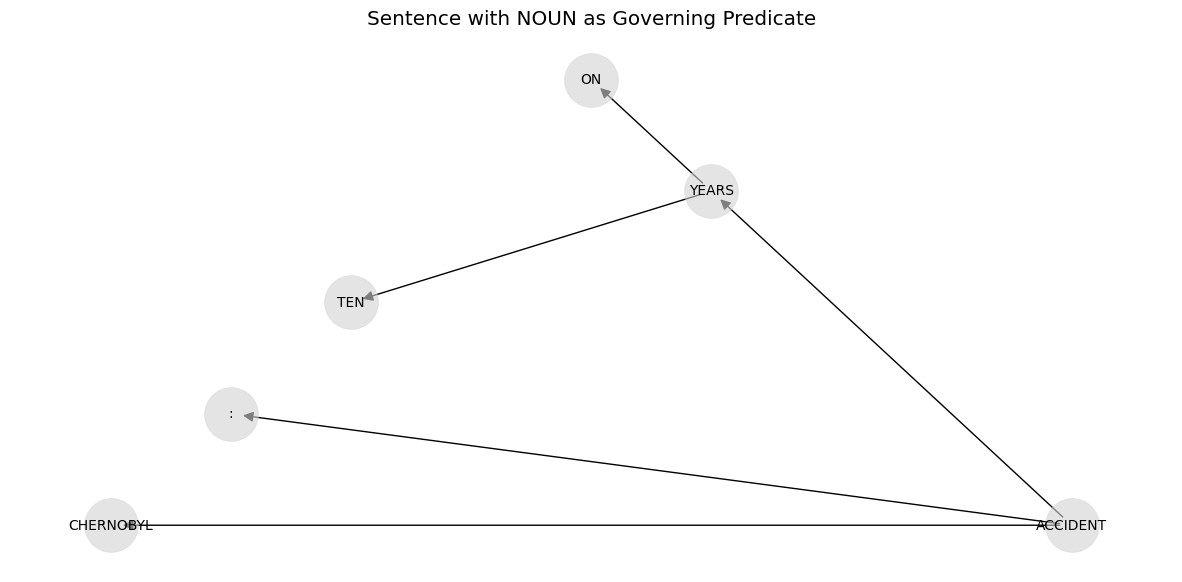

In [26]:
"""
Graph of sentence with other word (normally NOUN) as predicate
"""

sent_g = create_graph(train_data[75])
pos = nx.planar_layout(sent_g) 
node_labels = nx.get_node_attributes(sent_g, 'label')
edge_labels = nx.get_edge_attributes(sent_g, 'label')
plt.figure(figsize=(15, 7)) 
nx.draw_networkx_nodes(sent_g, pos, node_size=1500, node_color='lightgray', alpha=0.6)
nx.draw_networkx_edges(sent_g, pos, edgelist=sent_g.edges(), arrowstyle='-|>', arrowsize=15, width=1)
nx.draw_networkx_labels(sent_g, pos, node_labels, font_size=10)
nx.draw_networkx_edge_labels(sent_g, pos, edge_labels=edge_labels)
plt.axis('off')
plt.title('Sentence with NOUN as Governing Predicate')  
plt.show()

<div class="alert alert-block alert-warning"> <h2> 2. Prepare Train and Validation Set <h3> </div>

As it is allowed to use both train and dev dataset to train the model, I decide to combine both datasets and re-split them into train and val set, using only 15% for the latter. This approach ensure that I have more data to train the model and allow some labels to be presented in the validation set. Nevertheless, there are some labels with only one observation. In such case, I put them into the training set. After the split, there are 12,364 tokens in train set and 2,181 in val set.

Sample sentence in train set: [('1', 'I', 'I', 'PRON', 'PRP', 'Case=Nom|Number=Sing|Person=1|PronType=Prs', '2', 'nsubj', '2:nsubj', '_', '_', 'ARG0'), ('2', 'availed', 'avail', 'VERB', 'VBD', 'Mood=Ind|Tense=Past|VerbForm=Fin', '0', 'root', '0:root', '_', 'avail.01', 'V'), ('3', 'myself', 'myself', 'PRON', 'PRP', 'Case=Acc|Number=Sing|Person=1|PronType=Prs|Reflex=Yes', '2', 'obj', '2:obj', '_', '_', 'ARG1'), ('4', 'of', 'of', 'ADP', 'IN', '_', '9', 'case', '9:case', '_', '_', '_'), ('5', 'the', 'the', 'DET', 'DT', 'Definite=Def|PronType=Art', '9', 'det', '9:det', '_', '_', '_'), ('6', 'wash', 'wash', 'VERB', 'VB', 'VerbForm=Inf', '9', 'compound', '9:compound', '_', 'wash.01', '_'), ('7', "'n", 'and', 'CCONJ', 'CC', 'Abbr=Yes', '8', 'cc', '8:cc', '_', '_', '_'), ('8', 'fold', 'fold', 'VERB', 'VB', 'VerbForm=Inf', '6', 'conj', '6:conj:and|9:compound', '_', 'fold.03', '_'), ('9', 'service', 'service', 'NOUN', 'NN', 'Number=Sing', '2', 'obl', '2:obl:of', 'SpaceAfter=No', 'serve.01', 'ARG2

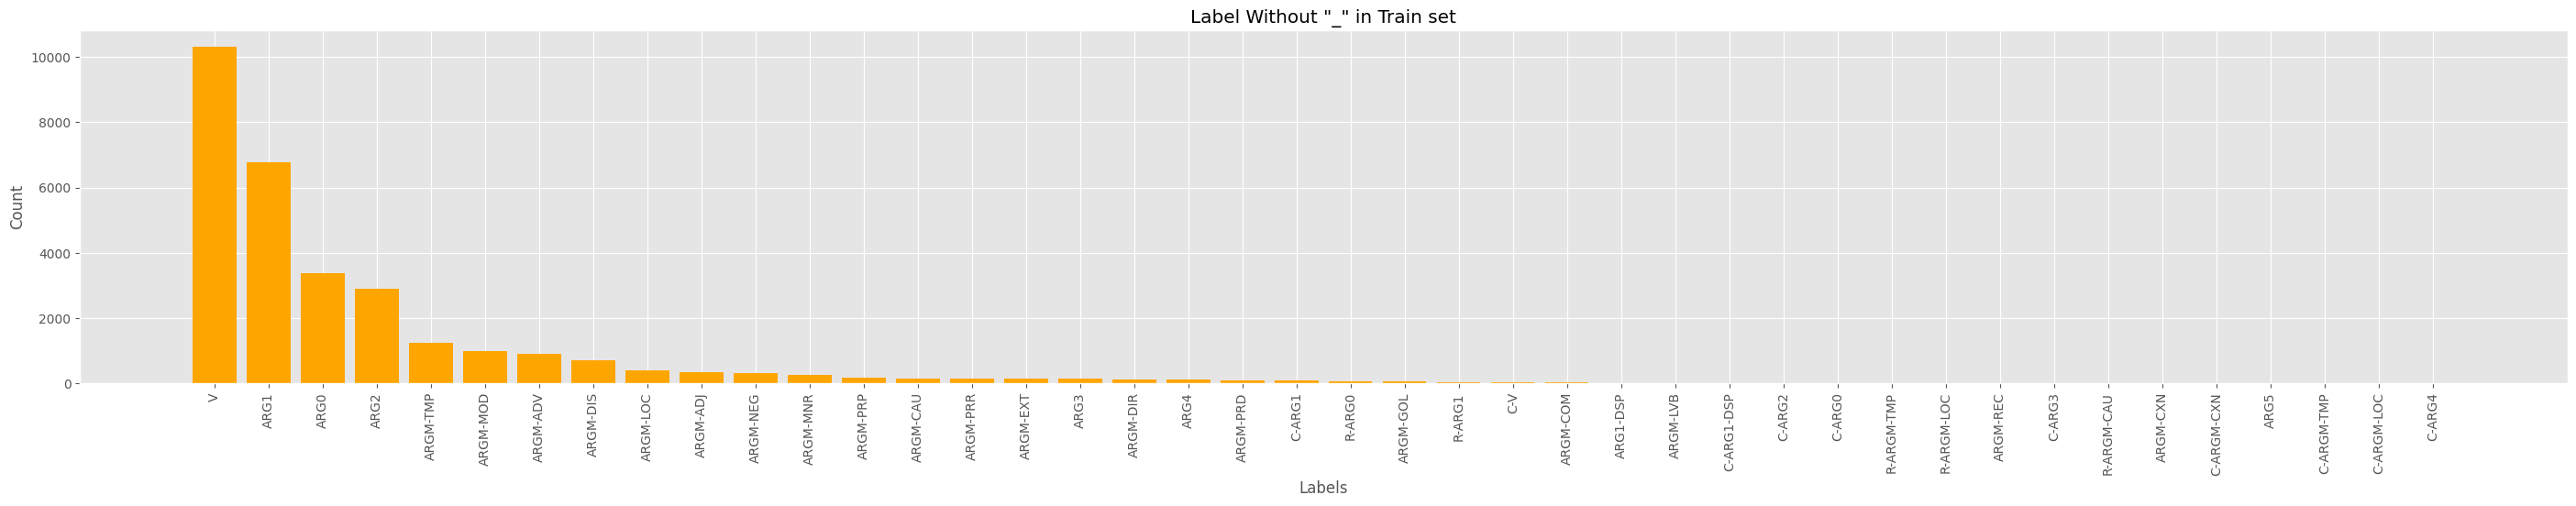

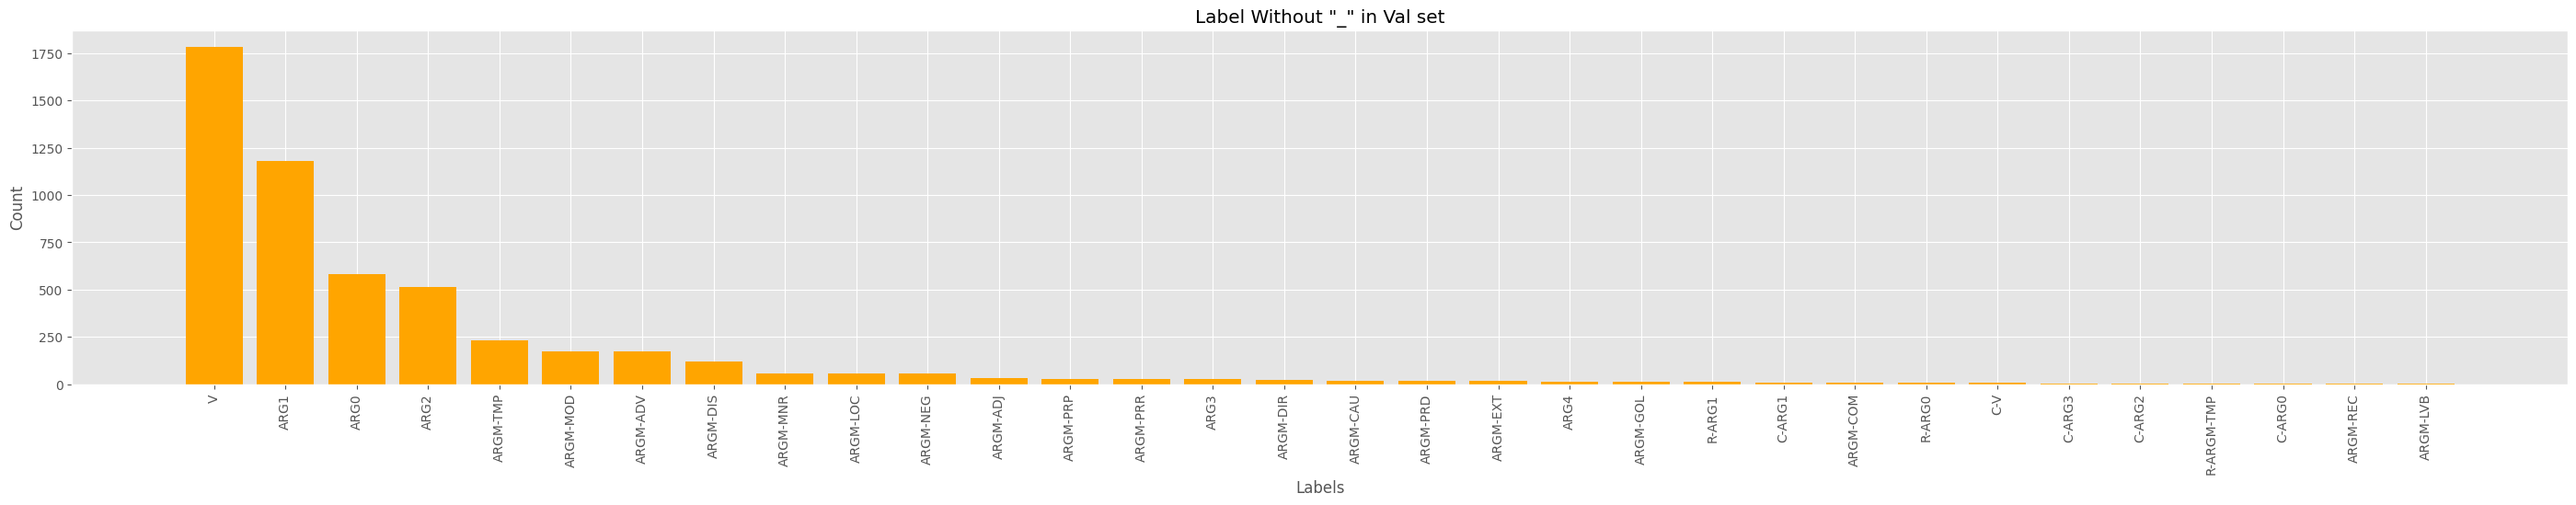

In [19]:
"""
Combine train and dev. 
Split train and val set.
"""

# Combine data
combined_data = train_data + dev_data

# Get label with one observation out and put it in train set
def separate_minor_label(data):
    
    # Flatten and extract labels
    labels = [token[11] for sentence in data for token in sentence if token[11] != "_"]
    
    # Count each label
    label_counts = Counter(labels)
    
    # Separate label with one observation
    train_data = [sentence for sentence in data if any(label_counts[token[11]] == 1 for token in sentence)]
    remaining_data = [sentence for sentence in data if sentence not in train_data]
    
    return train_data, remaining_data

initial_train_data, remaining_data = separate_minor_label(combined_data)

# Split train/test
train_set, val_set = train_test_split(remaining_data, test_size=0.15, random_state=40)

# Put the observation with one label to the train set
train_set.extend(initial_train_data)

# Check
print(f'Sample sentence in train set: {train_set[20]}')
print(f'Sample sentence in val set:{val_set[20]}')
print(f'Tokens in train set: {len(train_set)}')
print(f'Tokens in val set: {len(val_set)}')

# Check labels 
train_label_count = exclude_underscore(train_set, 11)
plot_values_count(train_label_count,11,'Label Without "_" in Train set')
val_label_count = exclude_underscore(val_set, 11)
plot_values_count(val_label_count,11,'Label Without "_" in Val set')


In [20]:
"""
Recheck label in each set
"""

train_set_counts = count_value(train_set, 11)
dev_set_counts = count_value(val_set, 11)

# Convert to dict to compare labels
train_set_dict = dict(train_set_counts)
dev_set_dict = dict(dev_set_counts)

# Identify unique label in each dataset
unique_train_set_labels = set(train_set_dict.keys()) - set(dev_set_dict.keys())
unique_dev_set_labels = set(dev_set_dict.keys()) - set(train_set_dict.keys())

# print
print('Labels unique to train dataset:')
for label in unique_train_set_labels:
    print(label)
print('\nLabels unique to dev dataset:')
for label in unique_dev_set_labels:
    print(label)


Labels unique to train dataset:
C-ARGM-LOC
ARGM-CXN
R-ARGM-LOC
C-ARGM-CXN
ARG1-DSP
C-ARG1-DSP
R-ARGM-CAU
C-ARG4
ARG5
C-ARGM-TMP

Labels unique to dev dataset:


<div class="alert alert-block alert-warning"> <h2> 3. Feature Design <h3> </div>

I incorporate a mixed set of features that leverage both syntactic and semantic contexts, essential for accurately predicting semantic role labels. This feature design employs dependency-based elements. Dependency-based features focus on the direct relationships between words, unlike the constituency-based parsing that focuses on hierarchical and nested structure (Jurafsky and Martin, 2020, p.11). It is noted that the feature design also follows the suggestion of Jurafsky and Martin (2020) The specific features developed for the model include:

**3.1 Morphological Features**

These features include token's lemma, universal part-of-speech (UPOS), language-specific part-of-speech (XPOS), dependency relations (DEPREL), and predicate sense (if it is predicate). They can help identify the sematic role of the token. For instance, different UPOS (part-of-speech tag) can facilitate the identification of its semantic role (i.e., VERB can act as a V). 

**3.2 Features based on Contextual Information (previous and next token)**

This include the tokens immediately before and after a given token, and their features such as lemma, UPOS, XPOS, DEPREL, and Grammatical Features. While Jurafsky and Martin (2020) do not include previous and next token as core common feature for SRL task, they can significantly influence the interpretation of the token's role in the sentence. For instance, if the preceding token is a verb in passive voice, it might suggest that the current token functions as a patient in a passive structure (ARG1). I also included **predicate sense** because different sense number refer to different predicate's meaning (see Figure 3), which also influence its dependents' form ad role in the sentence (Jurafsky and Martin, 2020, p. 102). 

**3.3 Features from Headword and Headword of Headword**

This is one of the core set of features mentioned by Jurafsky and Martin (2020). I also extracted the features (such as lemma, UPOS, XPOS, DEPREL, and Grammatical Feature) of the token's headword, identified by tracing back through the dependency tree using HEAD index and token's id (CONLL-U format, n.d.). The headword usually govern the syntactic role of the token. For instance, in the training dataset sentence 'Thanks a lot,' the headword 'Thanks governs the token 'lot,' which is labeled as ARGM-EXT (Extended Argument Modifier). Including this dependency relation allows the model to capture the functional link between them. Moreover, including grandparent features extends this hierarchical context, providing additional information about the headword’s own dependencies and its influence on the current token.

**3.4 Relationship with Children nodes**

I included the information about a token's children, because they can provide key details about the word’s semantic function in the sentence. For example, in the sentence “Thanks a lot,” the child node “lot”, which is ARGM-EXT (Extended Argument Modifier) helps clarify the role of the token “Thanks,” which is labeled as an VERB. By including features from child nodes, the model can capture these kinds of dependency relationships.

**3.5 Governing Predicate**

According to Jurafsky and Martin (2020), sematic roles are usually determined in relation to the governing predicate (i.e., verb in the sentence or noun in the clause/phrase). Hence, I included the **features of the governing predicate** such as root's LEMMA, UPOS, PREDICATE SENSE (if it is flagged as predicate). It is noted that I prioritised the governing predicate that is the **root verb** of the sentence, which usually influence the role of other tokens. However, some tokens do not linked up to the root verb because it is part of the phrase or clause. In this case, I traced back to the root as defined by 'DEPREL'. I also included the path length, distance, and linear position between the token its governing predicate. 


![predicate_sense](data/predicates.png){width=300}

*Figure 3: Predicate Sense and Semantic Roles.* Source: Conia, Simone & Barba, Edoardo & Scirè, Alessandro & Navigli, Roberto. (2022). Semantic Role Labeling Meets Definition Modeling: Using Natural Language to Describe Predicate-Argument Structures. 10.18653/v1/2022.findings-emnlp.313.



**References**

CONLL-U format. (n.d.). https://universaldependencies.org/format.html#morphological-annotation

Jurafsky, D., & Martin, J. (2020). Speech and Language Processing An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition Third Edition draft. https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf
‌


In [21]:
"""
Feature extractions
Reference: 
- https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#features
- https://www.geeksforgeeks.org/conditional-random-fields-crfs-for-pos-tagging-in-nlp/
"""

################################
# Function to get features
################################

def word2features(sent, i):
    
    lemma = sent[i][2]
    upos = sent[i][3]
    xpos = sent[i][4]
    grammar_feature = sent[i][5]
    syn_head_id = int(sent[i][6]) - 1   # Subtract 1 from syntactic head. In CoNLL-U, HEAD=5 points to the 5th word, this is at index 4 in python.
    deprel = sent[i][7]
    predicate = sent[i][10]
    
    ################################
    # Basic features
    ################################
    features = {
        'bias': 1.0,
        'word_lemma': lemma,
        'word_upos': upos, 
        'word_xpos': xpos, 
        'word_deprel': deprel,
    }
    
    # words grammar
    if grammar_feature != '_':
        word_feats = dict(feat.split('=') for feat in grammar_feature.split('|') if '=' in feat)
        features.update({f'word_{k}': v for k, v in word_feats.items()})
    
    # If it is predicate, get the sense
    if predicate != '_': 
        predicate_sense = predicate.split('.')[1]
        features['word_pred_sense'] = predicate_sense

    ################################
    # Dependency on previous word
    ################################
    if i > 0:
        prev_word = sent[i-1]
        features.update({
            'prev_word_lemma': prev_word[2],  
            'prev_word_upos': prev_word[3],  
            'prev_word_xpos': prev_word[4], 
            'prev_word_deprel': prev_word[7], 
        })
        
        # Previous word grammar features
        if prev_word[5] != '_':
            prev_feats = dict(feat.split('=') for feat in prev_word[5].split('|') if '=' in feat)
            features.update({f'prev_word_{k}': v for k, v in prev_feats.items()})
            
        # Previous word predicate sense
        if prev_word[10] != '_':
            prev_word_pred_sense = prev_word[10].split('.')[1] 
            features['prev_word_pred_sense'] = prev_word_pred_sense
        
        
    ################################
    # Dependency on next word
    ################################
    
    # Next word basic features
    if i < len(sent) - 1:
        next_word =sent[i+1]
        features.update({
            'next_word_lemma': next_word[2],
            'next_word_upos': next_word[3],  
            'next_word_xpos': next_word[4],
            'next_word_deprel': next_word[7],
        })
        
        # Next words grammar
        if next_word[5] != '_':
            next_feats = dict(feat.split('=') for feat in next_word[5].split('|') if '=' in feat)
            features.update({f'next_word_{k}': v for k, v in next_feats.items()})
            
        # Next words predicate sense
        if next_word[10] != '_': 
            next_word_predicate = next_word[10].split('.')[1]  
            features['next_word_pred_sense'] = next_word_predicate

        
    ################################
    # Dependency with head (parent tokens)
    ################################
    
    # linear position to token's head
    if syn_head_id > i:
        features['pos_to_head'] = 'before'
    elif syn_head_id < i:
        features['pos_to_head'] = 'after'
    else:
        features['pos_to_head'] = 'head'
    
    # Basic feature of head
    if 0 <= syn_head_id < len(sent):
        syn_head = sent[syn_head_id]
        features.update({
            'head_lemma': syn_head[2],  
            'head_upos': syn_head[3],  
            'head_xpos': syn_head[4], 
            'head_deprel': syn_head[7],
            'dist_to_head': abs(i - syn_head_id)
        })
        
        # Head grammar feat
        if syn_head[5] != '_':
            head_features = dict(feat.split('=') for feat in syn_head[5].split('|') if '=' in feat)
            features.update({f'head_{k}': v for k, v in head_features.items()})
            
        # Head Predicate
        if syn_head[10] != '_':
            head_pred_sense = syn_head[10].split('.')[1]
            features['head_pred_sense'] = head_pred_sense
            
        # Basic feature of head of head
        head_of_syn_head_id = int(sent[syn_head_id][6]) - 1 
        if 0 <= head_of_syn_head_id < len(sent):
            head_head = sent[head_of_syn_head_id]
            features.update({
                'head_head_lemma': head_head[2],
                'head_head_upos': head_head[3],
                'head_head_xpos': head_head[4], 
                'head_head_deprel': head_head[7],
            })
            # Head of head predicate
            if head_head[10] != '_':
                head_head_pred_sense = head_head[10].split('.')[1]
                features['head_head_pred_sense'] = head_head_pred_sense

    ################################
    # Dependency with children
    ################################
    
    # Get all children (one token  can have many children like root)
    children = []
    # Iterate through the sentence and check each token's head whether it points to current word's index
    for child_idx, token in enumerate(sent):
        if int(token[6]) - 1 == i:
            # If true, get the child index and token
            children.append((child_idx, token))

    # List to get child position
    children_before = []
    children_after = []

    # Iterate over each child in the list
    for child_idx, child in children:
        # split them into before and after position relative to current word based on index
        distance = child_idx - i
        if distance < 0: 
            children_before.append((child_idx, child))
        elif distance > 0: 
            children_after.append((child_idx, child))
            
    # Add features for all children before the token
    for idx, (child_idx, child) in enumerate(children_before):
        features[f'child_before_{idx+1}_lemma'] = child[2]
        features[f'child_before_{idx+1}_upos'] = child[3]
        features[f'child_before_{idx+1}_xpos'] = child[4]
        features[f'child_before_{idx+1}_deprel'] = child[7]

    # Add features for all children after the token
    for idx, (child_idx, child) in enumerate(children_after):
        features[f'child_after_{idx+1}_lemma'] = child[2]
        features[f'child_after_{idx+1}_upos'] = child[3]
        features[f'child_after_{idx+1}_xpos'] = child[4]
        features[f'child_after_{idx+1}_deprel'] = child[7]
    
    ################################
    # Dependency with governing predicate (ROOT VERB)
    ################################
    
    root_index = None
    true_verb_pred_index = None
    min_dist = float('inf')
    
    # Find the root and any VERB or AUX predicates
    for idx, token in enumerate(sent):
        
        # If the token is root, get its index
        if token[7] == 'root':
            root_index = idx

        # if token has value and is VERB or AUX
        if token[10] != '_' and (token[3] == 'VERB' or token[3] == 'AUX'):
            distance = 0  # initialise distance
            current_index = idx  # Get current index
            
            # While current token is not root and has index
            while current_index != root_index and current_index != -1:
                head_index = int(sent[current_index][6]) - 1  # get parent index
                if head_index == -1:
                    break
                distance += 1  # Cumulate distance
                current_index = head_index  # Update current index
            # if the updated index is now root and the distance is less than min distance
            if current_index == root_index and distance < min_dist:
                min_dist = distance  # Update min distance
                true_verb_pred_index = idx  # Set governing verb index
                
    # If governing verb is not found (no predicate verb), use the root index
    if true_verb_pred_index is None:
        true_verb_pred_index = root_index
        
    # Check if the current token is directly or indirectly connected to the governing predicate
    # Some token does not depend on governing verb (like in clause or phrase)
    is_connected_to_gov_pred = False
    check_index = i
    while check_index != -1:
        parent_index = int(sent[check_index][6]) - 1
        if parent_index == true_verb_pred_index:
            is_connected_to_gov_pred = True
            break
        check_index = parent_index

    # If token connect to ROOT VERB get the linear position to ROOT VERB
    if is_connected_to_gov_pred:
        features['dist_to_gov_pred'] = abs(i - true_verb_pred_index)
        if i < true_verb_pred_index:
            features['pos_to_gov_pred'] = 'before'
        elif i > true_verb_pred_index:
            features['pos_to_gov_pred'] = 'after'
        else:
            features['pos_to_gov_pred'] = 'gov_pred'
        
        # Calculate path length to governing predicate
        path_length = 0
        current_index = i
        visited_indices = set()
        while current_index != true_verb_pred_index and current_index not in visited_indices:
            visited_indices.add(current_index)
            parent_index = int(sent[current_index][6]) - 1
            if parent_index == -1 or parent_index == current_index:
                path_length = None
                break
            path_length += 1
            current_index = parent_index

        if path_length is not None:
            features['path_length_to_gov_pred'] = path_length
        else:
            features['path_length_to_gov_pred'] = 0
            
            
    ################################
    # Dependency with root that is not verb (in the case that root is not governing predicate)
    # This is found in sent that is just a clause or phrase (not full sentence)
    ################################
    
    # If token does not linked up to root verb, get linear position related to root that is not verb
    if true_verb_pred_index != root_index:
        features['dist_to_root'] = abs(i - root_index) # get token's distance to root
        
        # flag linear position of token relative to root
        if i < root_index:
            features['pos_to_root'] = 'before'
        elif i > root_index:
            features['pos_to_root'] = 'after'
        else:
            features['pos_to_root'] = 'root'

        # calculate path length to root that is not verb
        path_length_to_root = 0
        current_index = i
        visited_indices = set()  # Collect indices visited
        
        # While current index is not root and visited
        while current_index != root_index and current_index not in visited_indices:
            visited_indices.add(current_index)
            parent_index = int(sent[current_index][6]) - 1  # get the token parent index
            
            # if parent index is not available or is the current index
            if parent_index == -1 or parent_index == current_index:
                path_length_to_root = None  # set path length to none
                break
            path_length_to_root += 1  # Else cumulate the path lenght
            current_index = parent_index  # Reset the current index to the head (go up the path)

        # If the path length is available, set path length
        if path_length_to_root is not None:
            features['path_length_to_root'] = path_length_to_root
        else:
            features['path_length_to_root'] = 0

    return features

################################
# Function for features and labels
################################

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label[11] for label in sent]

################################
# Function to check all feature names in the train dataset
################################

def retrieve_features(sents, max_sents=500):
    feature_names = set()
    for idx, sent in enumerate(sents):
        features_in_sent = sent2features(sent)
        for features in features_in_sent:
            feature_names.update(features.keys())
        if idx >= max_sents:
            break
    return feature_names

all_features = retrieve_features(train_set)
print(all_features)

{'prev_word_Tense', 'child_before_4_lemma', 'child_after_2_xpos', 'prev_word_Number', 'next_word_lemma', 'next_word_upos', 'prev_word_deprel', 'child_after_1_lemma', 'prev_word_NumType', 'child_before_5_xpos', 'head_head_lemma', 'prev_word_Voice', 'child_after_9_lemma', 'child_before_6_lemma', 'child_after_9_upos', 'child_after_10_xpos', 'child_before_1_deprel', 'head_Gender', 'child_after_2_upos', 'child_after_1_upos', 'child_before_4_xpos', 'head_PronType', 'child_after_5_lemma', 'head_Tense', 'child_before_3_lemma', 'next_word_Abbr', 'child_after_8_xpos', 'child_after_9_xpos', 'child_after_4_upos', 'head_upos', 'head_Mood', 'child_after_7_lemma', 'head_Degree', 'word_upos', 'child_before_7_lemma', 'child_before_5_lemma', 'child_before_1_lemma', 'child_after_6_lemma', 'head_head_xpos', 'prev_word_xpos', 'next_word_NumType', 'next_word_Definite', 'word_Reflex', 'child_after_6_xpos', 'child_before_1_xpos', 'head_VerbForm', 'word_NumType', 'dist_to_head', 'word_Typo', 'child_before_2_le

In [22]:
"""
Get features and labels from the dataset
References:
- https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb
"""

# X
X_train = [sent2features(s) for s in train_set]
X_val = [sent2features(s) for s in val_set]
X_test = [sent2features(s) for s in test_data]

# y
y_train = [sent2labels(s) for s in train_set]
y_val = [sent2labels(s) for s in val_set]

print(f'Length of X_train, {len(X_train)}')
print(f'Length of y_train, {len(y_train)}')

# Check feature design
print(f'Sample feature in X train base: {X_train[13][5]}')
# Check label extract
print(f'Sample label in y train base: {y_train[13][5]}')

Length of X_train, 12364
Length of y_train, 12364
Sample feature in X train base: {'bias': 1.0, 'word_lemma': 'in', 'word_upos': 'ADP', 'word_xpos': 'IN', 'word_deprel': 'case', 'prev_word_lemma': 'left', 'prev_word_upos': 'NOUN', 'prev_word_xpos': 'NN', 'prev_word_deprel': 'obl', 'prev_word_Number': 'Sing', 'next_word_lemma': 'circle', 'next_word_upos': 'NOUN', 'next_word_xpos': 'NNS', 'next_word_deprel': 'obl', 'next_word_Number': 'Plur', 'pos_to_head': 'before', 'head_lemma': 'circle', 'head_upos': 'NOUN', 'head_xpos': 'NNS', 'head_deprel': 'obl', 'dist_to_head': 1, 'head_Number': 'Plur', 'head_head_lemma': 'lope', 'head_head_upos': 'VERB', 'head_head_xpos': 'VB', 'head_head_deprel': 'root', 'head_head_pred_sense': '01', 'dist_to_gov_pred': 5, 'pos_to_gov_pred': 'after', 'path_length_to_gov_pred': 2}
Sample label in y train base: _


<div class="alert alert-block alert-warning"> <h2> 4. Baseline Model<h3> </div>

<div class="alert alert-block alert-success"> <h3> 4.1 Baseline Model and Evaluation <h3> </div>


The baseline model is constructed without hyperparameter tuning. I configure the model with L-BEFGS algorithm with L1 (c1) and L2 (c2) regularisation equals to 0.1. I also configure the model to handle all possible transitions and states to ensure it can model a wide range of potential label sequences. The *all_possible_transition* helps generate "transition features that do not even occur in the training data", while *all_possible_states* can help "improve the labelling accuracy because the CRF model can learn condition where an item is not predicted to its reference label (API Reference — Sklearn-Crfsuite 0.3 Documentation, n.d.).

I train the model on the train set and validate the model on the validation set. During the evaluation, I exclude the default label '_' to focus on the labelled semantic roles. flat_classification_report from sklearn-crfsuite to evaluate the model, providing metrics for each label.

Overall, the model achieve macro F1 of 0.4014. It show strong performance for common labels such as ARG0, V, and ARG1, with each label's F1 scores of 0.87, 0.91, and 0.76, respectively. Other labels, such as ARG2, ARGM-MOD, and ARGM-NEG, also achieve relatively high F1 scores. However, less frequent labels, such as ARG3 and ARGM-LOC, had lower F1 scores, suggesting that the model struggles with rare labels. Additionally, the model performs poorly on rare classes like ARGM-GOL, ARGM-CAU, reflecting the challenge of accurate prediction for less common labels.
 

I use confusion matrix to further investigate the model performance. It shows that the model is highly effective in predicting core roles such as 'ARG0', 'V', and 'ARG1', with high true positive counts. However, some confusion can be found among 'ARG' label. For instance, ARG1 (PROTO-PATIENT) is often misclassified as ARG0 (PROTO-AGENT) and ARG2 (Instrument, Beneficiary, or End State). ARG0 is often misclassified as ARG1, similar to ARG2. This phenomenon reflects challenges in distinguishing between these similar semantic roles in the sentence. 

Finally, I examine the error rate of the baseline model, excluding '_' label. It achieves an accuracy of 0.7826, or correctly labels about 78% of the semantic roles. This leaves an error rate of 0.2174, showing that around 22% of the roles are misclassified.

**References:**

API Reference — sklearn-crfsuite 0.3 documentation. (n.d.). Sklearn-Crfsuite.readthedocs.io. https://sklearn-crfsuite.readthedocs.io/en/latest/api.html


In [23]:
"""
Construct the baseline model
References
- https://github.com/nlptown/nlp-notebooks/blob/master/Named%20Entity%20Recognition%20with%20Conditional%20Random%20Fields.ipynb
- https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
"""

# Initialise model
crf_mod_base = sklearn_crfsuite.CRF(
    c1=0.1,
    c2=0.1,
    algorithm='lbfgs',
    max_iterations=200,
    all_possible_transitions=True,  
    all_possible_states = True 
)

# Fit
crf_mod_base.fit(X_train, y_train)

# Predict
y_pred_crf_mod_base = crf_mod_base.predict(X_val)

# Exclude the "_" label to evaluate model
labels = list(crf_mod_base.classes_)  # get label from the model
focused_labels = [label for label in labels if label != "_"]
print('Original Labels')
print(labels)
print('\nList of Focused labels')
print(focused_labels)

# Evaluate on val set
print('\nBase Model Evaluation:')
print(metrics.flat_classification_report(y_val, y_pred_crf_mod_base, labels=focused_labels, zero_division=0, digits=4))


Original Labels
['_', 'ARG0', 'V', 'ARG1', 'ARGM-EXT', 'ARG2', 'ARGM-DIS', 'ARGM-TMP', 'ARG3', 'ARGM-LOC', 'ARGM-DIR', 'ARGM-MOD', 'ARGM-NEG', 'C-ARG1', 'ARGM-ADV', 'C-V', 'R-ARG0', 'ARGM-PRR', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARG4', 'R-ARG1', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-COM', 'ARG1-DSP', 'C-ARG1-DSP', 'C-ARG2', 'ARGM-PRD', 'ARGM-LVB', 'R-ARGM-TMP', 'C-ARG0', 'ARGM-REC', 'C-ARG3', 'R-ARGM-LOC', 'R-ARGM-CAU', 'ARGM-CXN', 'C-ARGM-CXN', 'ARG5', 'C-ARGM-TMP', 'C-ARGM-LOC', 'C-ARG4']

List of Focused labels
['ARG0', 'V', 'ARG1', 'ARGM-EXT', 'ARG2', 'ARGM-DIS', 'ARGM-TMP', 'ARG3', 'ARGM-LOC', 'ARGM-DIR', 'ARGM-MOD', 'ARGM-NEG', 'C-ARG1', 'ARGM-ADV', 'C-V', 'R-ARG0', 'ARGM-PRR', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARG4', 'R-ARG1', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-COM', 'ARG1-DSP', 'C-ARG1-DSP', 'C-ARG2', 'ARGM-PRD', 'ARGM-LVB', 'R-ARGM-TMP', 'C-ARG0', 'ARGM-REC', 'C-ARG3', 'R-ARGM-LOC', 'R-ARGM-CAU', 'ARGM-CXN', 'C-ARGM-CXN', 'ARG5', 'C-ARGM-TMP', 'C-ARGM-LOC', 'C-ARG4']

Base Model Evalu

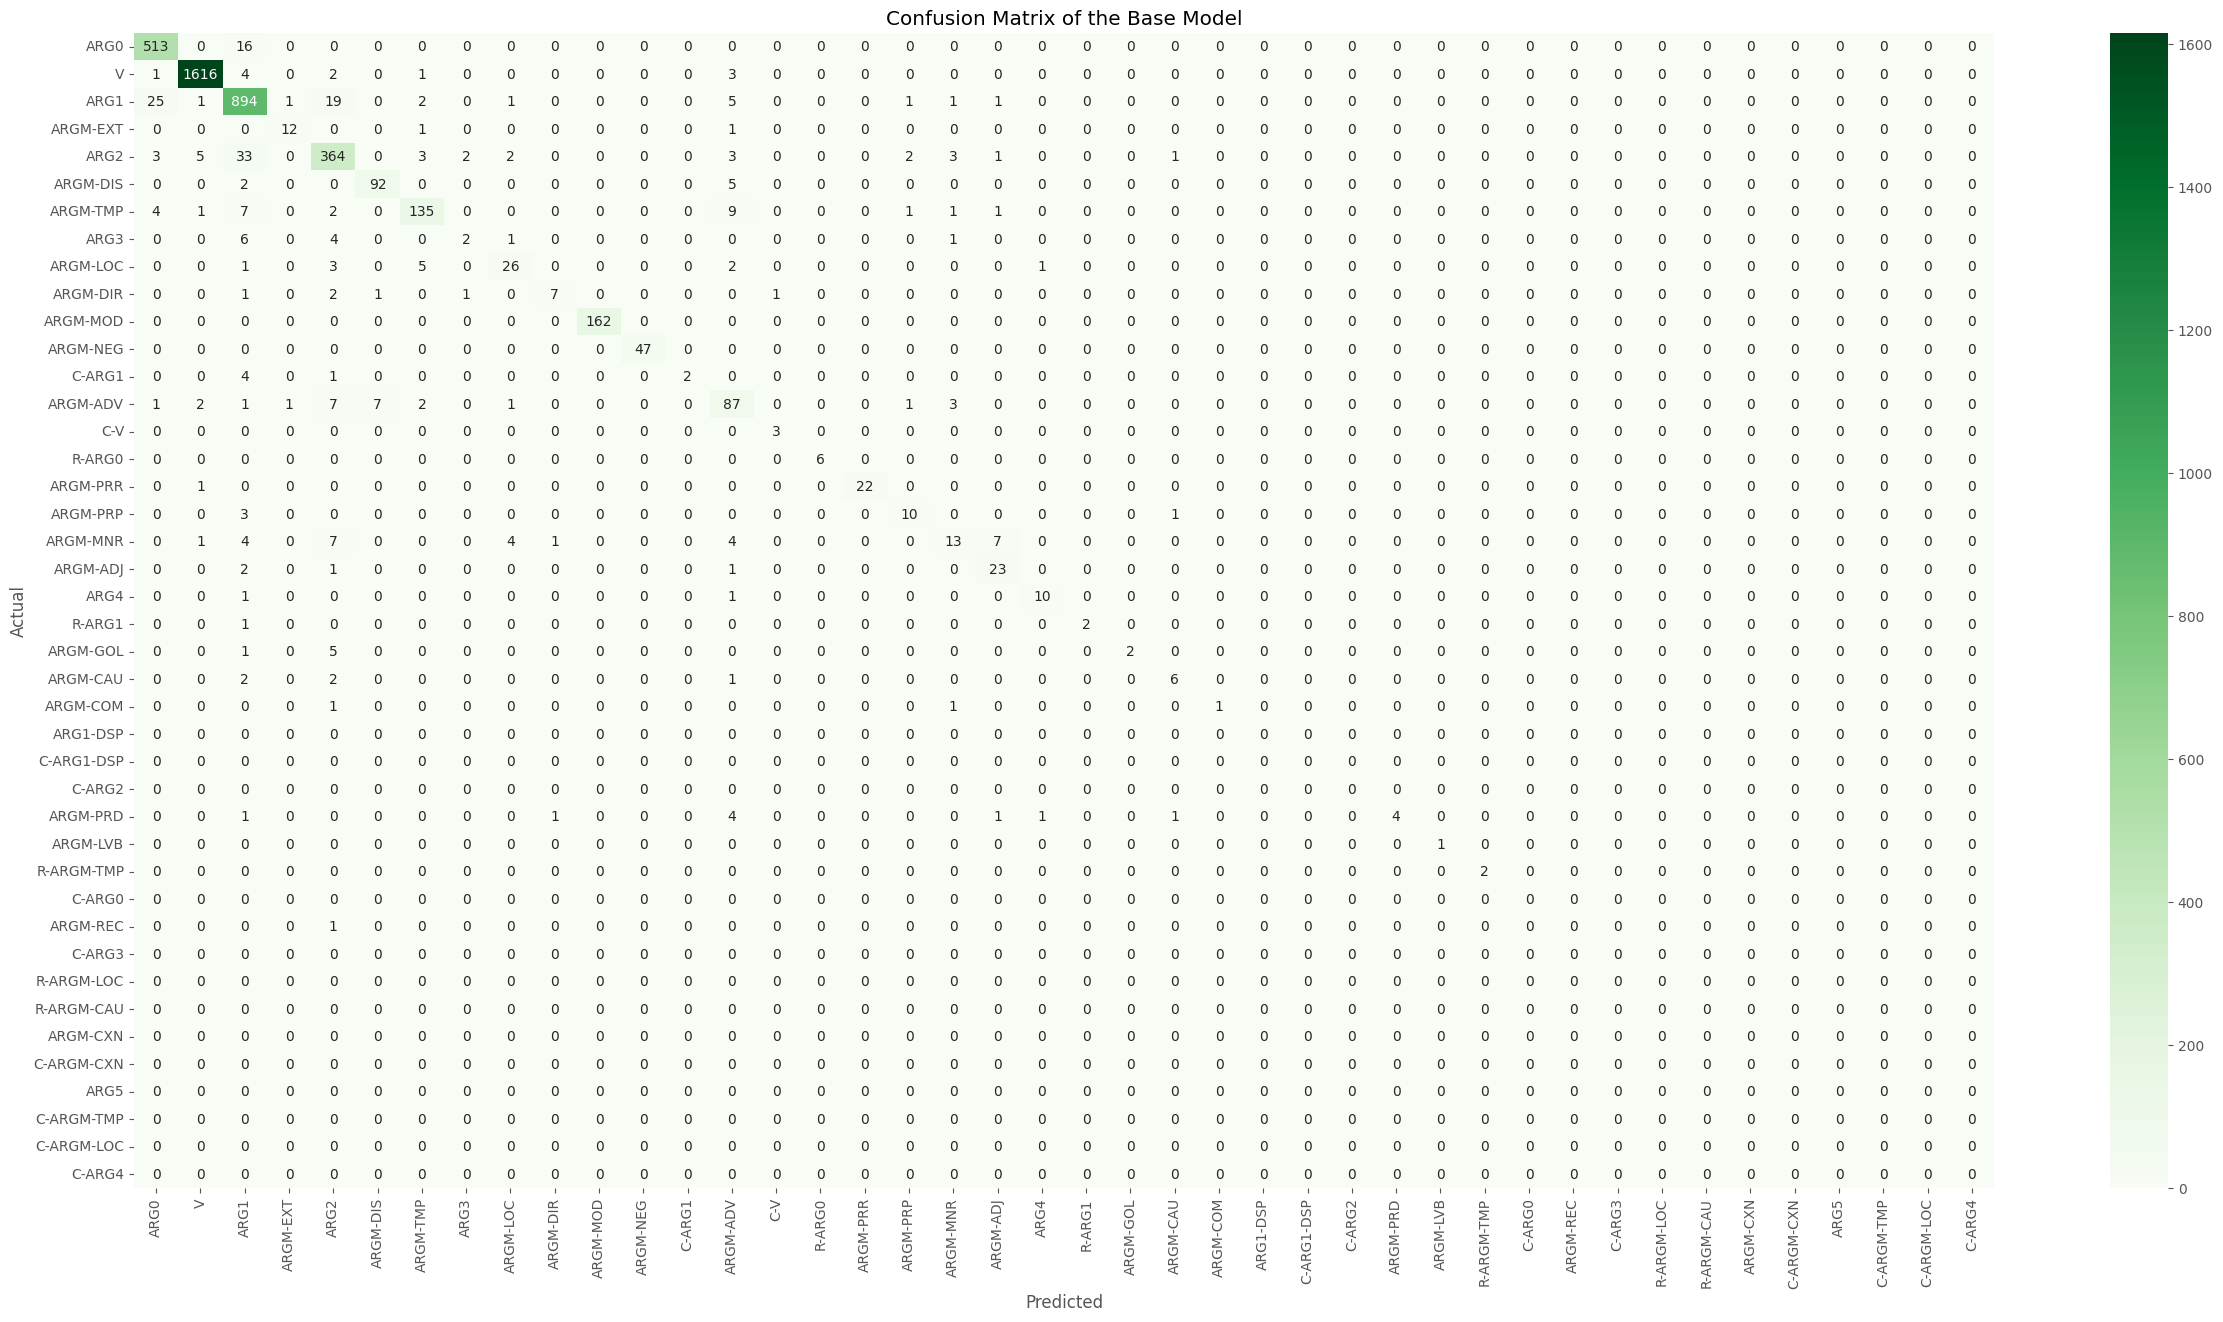

In [24]:
"""
Inspect confusion matrix
"""

# Flatten data 
y_val_flat = flatten(y_val)
y_pred_crf_mod_base_flat = flatten(y_pred_crf_mod_base)

# Generate the confusion matrix
cm_mod_base = confusion_matrix(y_val_flat, y_pred_crf_mod_base_flat, labels=focused_labels)

plt.figure(figsize=(30, 15))
sns.heatmap(cm_mod_base, annot=True, fmt="d", cmap="Greens", xticklabels=focused_labels, yticklabels=focused_labels)
plt.title('Confusion Matrix of the Base Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [20]:
"""
Investigate Error
"""

# Filter out "_" 
filtered_y_val_mod_base = [actual for actual, pred in zip(y_val_flat, y_pred_crf_mod_base_flat) if actual != "_"]
filtered_y_pred_mod_base = [pred for actual, pred in zip(y_val_flat, y_pred_crf_mod_base_flat) if actual != "_"]
accuracy_mod_2 = accuracy_score(filtered_y_val_mod_base, filtered_y_pred_mod_base )


# Calculate error rate
error_mod_2 = 1 - accuracy_mod_2
print(f'Baseline Model:')
print(f'Accuracy: {accuracy_mod_2:.4f}')
print(f'Error Rate: {error_mod_2:.4f}')


Baseline Model:
Accuracy: 0.7826
Error Rate: 0.2174


<div class="alert alert-block alert-success"> <h3> 4.2 Possible Transitions <h3> </div>

I inspect the top likely transition from the model. For instance, ARG1-DSP often transitions to itself. ARG0 frequently transitions to R-ARG0, which makes sense because agents often have references. Transitions from V to ARG2 and ARG1 are also common, reflecting how verbs are usually followed by their main arguments, like agents or themes. I notice that ARGM-TMP (temporal) transitions to ARGM-LVB (light verb), suggesting that time modifiers often pair with actions in sequence. On the other hand, some transitions are very unlikely. For instance, V -> V doesn’t happen often, as verbs typically lead to arguments instead of other verbs (also make sense). ARG2 -> ARG0 is also rare, likely because these are distinct roles with different functions. 

In [21]:
"""
Inspecting transition
References:
- https://github.com/scrapinghub/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb
- https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb
"""

# Function to get top and bottom transition
def get_transitions(crf, n=10):
    print("\nTop likely transitions:")
    for (label_from, label_to), weight in sorted(crf.transition_features_.items(), key=lambda item: item[1], reverse=True)[:n]:
        print(f"{label_from} -> {label_to}: {weight:.6f}")
    
    print("\nTop unlikely transitions:")
    for (label_from, label_to), weight in sorted(crf.transition_features_.items(), key=lambda item: item[1])[:n]:
        print(f"{label_from} -> {label_to}: {weight:.6f}")
        
# Check transition in baseline mod
get_transitions(crf_mod_base)


Top likely transitions:
ARG1-DSP -> ARG1-DSP: 4.767863
ARG0 -> R-ARG0: 4.615831
V -> ARG2: 4.605960
ARGM-TMP -> ARGM-LVB: 3.568871
ARG1 -> R-ARG1: 3.524886
V -> ARG1: 3.370387
V -> ARGM-PRR: 2.915006
ARGM-MOD -> ARGM-NEG: 2.856037
V -> ARGM-DIR: 2.783037
ARGM-NEG -> V: 2.616979

Top unlikely transitions:
V -> V: -5.359023
ARGM-MOD -> _: -4.584158
V -> ARGM-MOD: -3.376790
_ -> ARGM-MOD: -3.332319
ARG2 -> ARG0: -3.019604
ARGM-LOC -> V: -2.810440
R-ARG0 -> _: -2.662894
_ -> V: -2.650607
ARG0 -> _: -2.541384
R-ARG1 -> _: -2.431033


<div class="alert alert-block alert-success"> <h3> 4.3 Feature Weights <h3> </div>

Looking at the feature weights, the predicate sense is particularly important, especially for verbs. For example, word_pred_sense:02 has a high weight for V, which is common. The lemma of certain words also stands out. For instance, "never" is heavily weighted for ARGM-NEG (negation), which is also align with its true role in sentence structure. I also notice that dependency-related features like the lemma of the head word (e.g., "be" for ARG0) and the position relative to the head (like pos_to_head:before for ARG1) help the model understand relationships between words.

Looking at overall absolute weight, I found that the features for children nodes are ranked at the bottom of the list. This might indicate that the children features provide less unique information or overlap with other higher-weighted features, making their impact on the model relatively minimal.

In [23]:
"""
Check absolute weight of the features
"""

# Function to get top and buttom weight
def get_feat_weights(feat_weight, top=20, bottom=30):
    
    # Top
    print('Top features')
    top_features = [f for f in feat_weight[:top] if f[0][1] != '_']  # Exclude "_"
    for feature, weight in top_features:
        print(f"Feature: {feature}, Absolute Weight: {abs(weight)}")

    # Bottom
    print('\nBottom features')
    bottom_features = [f for f in feat_weight[-bottom:] if f[0][1] != '_']
    for feature, weight in bottom_features:
        print(f"Feature: {feature}, Absolute Weight: {abs(weight)}")

# get feature state
feat_weight_mod_base = crf_mod_base.state_features_
# Sort
feat_weight_mod_base_sort = sorted(feat_weight_mod_base.items(), key=lambda x: abs(x[1]), reverse=True)
# Show weights
get_feat_weights(feat_weight_mod_base_sort)



Top features
Feature: ('word_pred_sense:02', 'V'), Absolute Weight: 9.362339
Feature: ('head_pred_sense:LV', 'ARGM-PRR'), Absolute Weight: 8.585082
Feature: ('word_pred_sense:01', 'V'), Absolute Weight: 8.504994
Feature: ('word_pred_sense:03', 'V'), Absolute Weight: 8.491727
Feature: ('word_pred_sense:LV', 'V'), Absolute Weight: 7.841974
Feature: ('word_pred_sense:04', 'V'), Absolute Weight: 7.408911
Feature: ('word_pred_sense:05', 'V'), Absolute Weight: 7.181841
Feature: ('word_lemma:never', 'ARGM-NEG'), Absolute Weight: 6.976446
Feature: ('prev_word_pred_sense:01', 'V'), Absolute Weight: 6.724176
Feature: ('word_pred_sense:12', 'V'), Absolute Weight: 6.187802
Feature: ('head_lemma:be', 'ARG0'), Absolute Weight: 6.091518
Feature: ('pos_to_head:before', 'ARG1'), Absolute Weight: 5.882321
Feature: ('child_before_1_lemma:because', 'ARGM-CAU'), Absolute Weight: 5.447154
Feature: ('word_lemma:not', 'ARGM-NEG'), Absolute Weight: 5.314525
Feature: ('word_pred_sense:07', 'V'), Absolute Weight

In [24]:
"""
Investigate absolute weight from CRF model
"""

abs_weights = defaultdict(float)

# Iterate through the state features and their weights
for (feature, label), weight in feat_weight_mod_base.items():
    # Get attribute name
    attr_name = feature.split(':')[0]
    # Sum the abs weight
    abs_weights[attr_name] += abs(weight)  
    
sort_attr = sorted(abs_weights.items(), key=lambda x: x[1], reverse=True)

print('Total absolute weight of each attribute')
for attr, total_abs_weight in sort_attr:
    print(f'{attr}, {total_abs_weight:.4f}')


Total absolute weight of each attribute
word_lemma, 5801.6899
head_lemma, 4961.5630
prev_word_lemma, 3119.2809
next_word_lemma, 2796.5452
child_after_1_lemma, 2796.5229
head_head_lemma, 2179.0212
child_before_1_lemma, 1524.6241
child_before_2_lemma, 1144.4702
child_after_2_lemma, 952.5012
child_before_3_lemma, 694.5354
word_deprel, 468.2410
child_after_3_lemma, 247.5464
head_pred_sense, 237.5323
prev_word_deprel, 227.9302
next_word_deprel, 227.4708
child_before_4_lemma, 212.4014
head_deprel, 211.3789
word_pred_sense, 195.2028
word_xpos, 193.2063
word_upos, 167.6583
prev_word_xpos, 166.5920
next_word_xpos, 166.3289
head_head_deprel, 132.4145
child_before_1_deprel, 125.0459
child_after_1_deprel, 121.7961
prev_word_pred_sense, 113.8440
child_after_1_xpos, 110.7735
next_word_pred_sense, 110.4801
head_head_xpos, 109.5462
child_before_1_xpos, 106.2251
head_xpos, 105.8255
child_before_2_deprel, 99.4224
head_head_pred_sense, 98.6882
child_before_2_xpos, 97.6653
child_before_5_lemma, 88.3277
ch

<div class="alert alert-block alert-warning"> <h2> 5. Model 3 with Hyperparameter Tuning <h3> </div>

***WARNING - Hyperparameter tuning takes 6 hours to complete. The final model can be loaded and applied in the next section for prediction***


One of the strengths of CRFs is that they can manage large features set without requiring to explicitly perform feature selection. Instead, they use regularization such as L1 and L2 penalties to control the influence of features based on its contribution to the model's performance. Hence, I incorporate hyperparameter tuning, specifically tuning L1 and L2 regularization coefficients, along with parameters like max_iterations to ensure the model has enough time to converge. I also use all_possible_transitions and all_possible_states, which allow the model to consider transitions and states that didn’t appear in the training data but might be relevant. This helps the model generalize better to unseen sequences. The tuning model is evaluated using macro F1 score, achieving. 

The best model parameters include 
 - all_possible_states': False, 
 - 'all_possible_transitions': True, 
 - 'c1': 0.3370573040630146, 
 - 'c2': 0.06640163917149343, 
 - 'max_iterations': 200

They are also saved to JSON for ease of being employed later and future use.

I use the best model parameters on validation set, which achieves macro F1 score of 0.4093 - very closed to the baseline model. I examine the model with confusion matrix and spot the similar pattern with the baseline model. It performs well with high accuracy on the most frequent labels, such as ARG0, V, and ARG1. However, misclassifications are visible in several areas, particularly in labels with similar roles such as ARG0, ARG1, ARG2. Moreover, the error rate is also similar to the base with accuracy of 0.7857 excluding "_".


In [25]:
"""
Model 3 with hyperparameter tuning
References:
- https://www.kaggle.com/code/shoumikgoswami/ner-using-random-forest-and-crf
- https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/
"""


crf_mod_tune = sklearn_crfsuite.CRF(
    algorithm='lbfgs')

# Define the parameter distribution
param_space = {
    'c1': scipy.stats.uniform(0.01, 1),
    'c2': scipy.stats.uniform(0.01, 1),
    'max_iterations': [200, 250, 300, 350, 400],
    'all_possible_transitions': [True, False],
    'all_possible_states': [True, False]
}

# Evaluate 
macro_f1_scorer = make_scorer(metrics.flat_f1_score, average='macro', labels=focused_labels, zero_division=0)

# Random search
rs_crf_mod_tune = RandomizedSearchCV(crf_mod_tune, param_space, cv=5, verbose=1, random_state=50, n_jobs=1, n_iter=15, scoring=macro_f1_scorer)

# Fit model
rs_crf_mod_tune.fit(X_train, y_train)
rs_crf_mod_tune


Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=CRF(algorithm='lbfgs'), n_iter=15, n_jobs=1,
                   param_distributions={'all_possible_states': [True, False],
                                        'all_possible_transitions': [True,
                                                                     False],
                                        'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcb03d55130>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fcae64683a0>,
                                        'max_itera...
                   scoring=make_scorer(flat_f1_score, response_method='predict', average=macro, labels=['ARG0', 'V', 'ARG1', 'ARGM-EXT', 'ARG2', 'ARGM-DIS', 'ARGM-TMP', 'ARG3', 'ARGM-LOC', 'ARGM-DIR', 'ARGM-MOD', 'ARGM-NEG', 'C-ARG1', 'ARGM-ADV', 'C-V', 'R-ARG0', 'ARGM-PRR', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARG4', 'R-ARG1', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-COM', 'ARG1-DSP', 'C-ARG1-DSP', 'C-ARG2', 'ARGM-PRD', 'ARGM-LVB', 'R-ARGM-TMP', 'C-ARG0', 'ARGM-REC', 'C-ARG3', 'R-ARGM-LOC', 'R-ARGM-CAU', 'ARGM-CXN', 'C-ARGM-CXN', 'ARG5', 'C-ARGM-TMP', 'C-ARGM-LOC', 'C-ARG4'], zero_division=0),
                   verbose=1)

In [26]:
"""
Inspect best hyperparameters and save to JSON
"""

# Show best hyperparameters
best_params_crf_mod_tune = rs_crf_mod_tune.best_params_
best_macro_f1_mod_tune = rs_crf_mod_tune.best_score_
print(f'Best Macro F1: {best_macro_f1_mod_tune:.4f}')
print(f'Best parameters: {best_params_crf_mod_tune}')

# Save model
with open('data/best_params_crf_mod_tune.json', 'w') as file:
    json.dump(best_params_crf_mod_tune, file)

Best Macro F1: 0.3549
Best parameters: {'all_possible_states': False, 'all_possible_transitions': True, 'c1': 0.3370573040630146, 'c2': 0.06640163917149343, 'max_iterations': 200}


In [18]:
"""
Load model and evaluate model on val set with best params
"""

# Load best params
with open('data/best_params_crf_mod_tune.json', 'r') as file:
    best_params_crf_mod_tune_file = json.load(file)

# Fit model
crf_model_tune_param = sklearn_crfsuite.CRF(algorithm='lbfgs', **best_params_crf_mod_tune_file)
crf_model_tune_param.fit(X_train, y_train)

# Evaluate on validation set
y_pred_crf_mod_tune = crf_model_tune_param.predict(X_val)

# Reuse code in case, run only loaded model
labels = list(crf_model_tune_param.classes_)
focused_labels = [label for label in labels if label != "_"]
print('Original Labels')
print(labels)
print('\nList of Focused labels')
print(focused_labels)

print("CRF Model Evaluation:")
print(metrics.flat_classification_report(y_val, y_pred_crf_mod_tune, labels=focused_labels, zero_division=0, digits=4))


Original Labels
['_', 'ARG0', 'V', 'ARG1', 'ARGM-EXT', 'ARG2', 'ARGM-DIS', 'ARGM-TMP', 'ARG3', 'ARGM-LOC', 'ARGM-DIR', 'ARGM-MOD', 'ARGM-NEG', 'C-ARG1', 'ARGM-ADV', 'C-V', 'R-ARG0', 'ARGM-PRR', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARG4', 'R-ARG1', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-COM', 'ARG1-DSP', 'C-ARG1-DSP', 'C-ARG2', 'ARGM-PRD', 'ARGM-LVB', 'R-ARGM-TMP', 'C-ARG0', 'ARGM-REC', 'C-ARG3', 'R-ARGM-LOC', 'R-ARGM-CAU', 'ARGM-CXN', 'C-ARGM-CXN', 'ARG5', 'C-ARGM-TMP', 'C-ARGM-LOC', 'C-ARG4']

List of Focused labels
['ARG0', 'V', 'ARG1', 'ARGM-EXT', 'ARG2', 'ARGM-DIS', 'ARGM-TMP', 'ARG3', 'ARGM-LOC', 'ARGM-DIR', 'ARGM-MOD', 'ARGM-NEG', 'C-ARG1', 'ARGM-ADV', 'C-V', 'R-ARG0', 'ARGM-PRR', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARG4', 'R-ARG1', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-COM', 'ARG1-DSP', 'C-ARG1-DSP', 'C-ARG2', 'ARGM-PRD', 'ARGM-LVB', 'R-ARGM-TMP', 'C-ARG0', 'ARGM-REC', 'C-ARG3', 'R-ARGM-LOC', 'R-ARGM-CAU', 'ARGM-CXN', 'C-ARGM-CXN', 'ARG5', 'C-ARGM-TMP', 'C-ARGM-LOC', 'C-ARG4']
CRF Model Evaluat

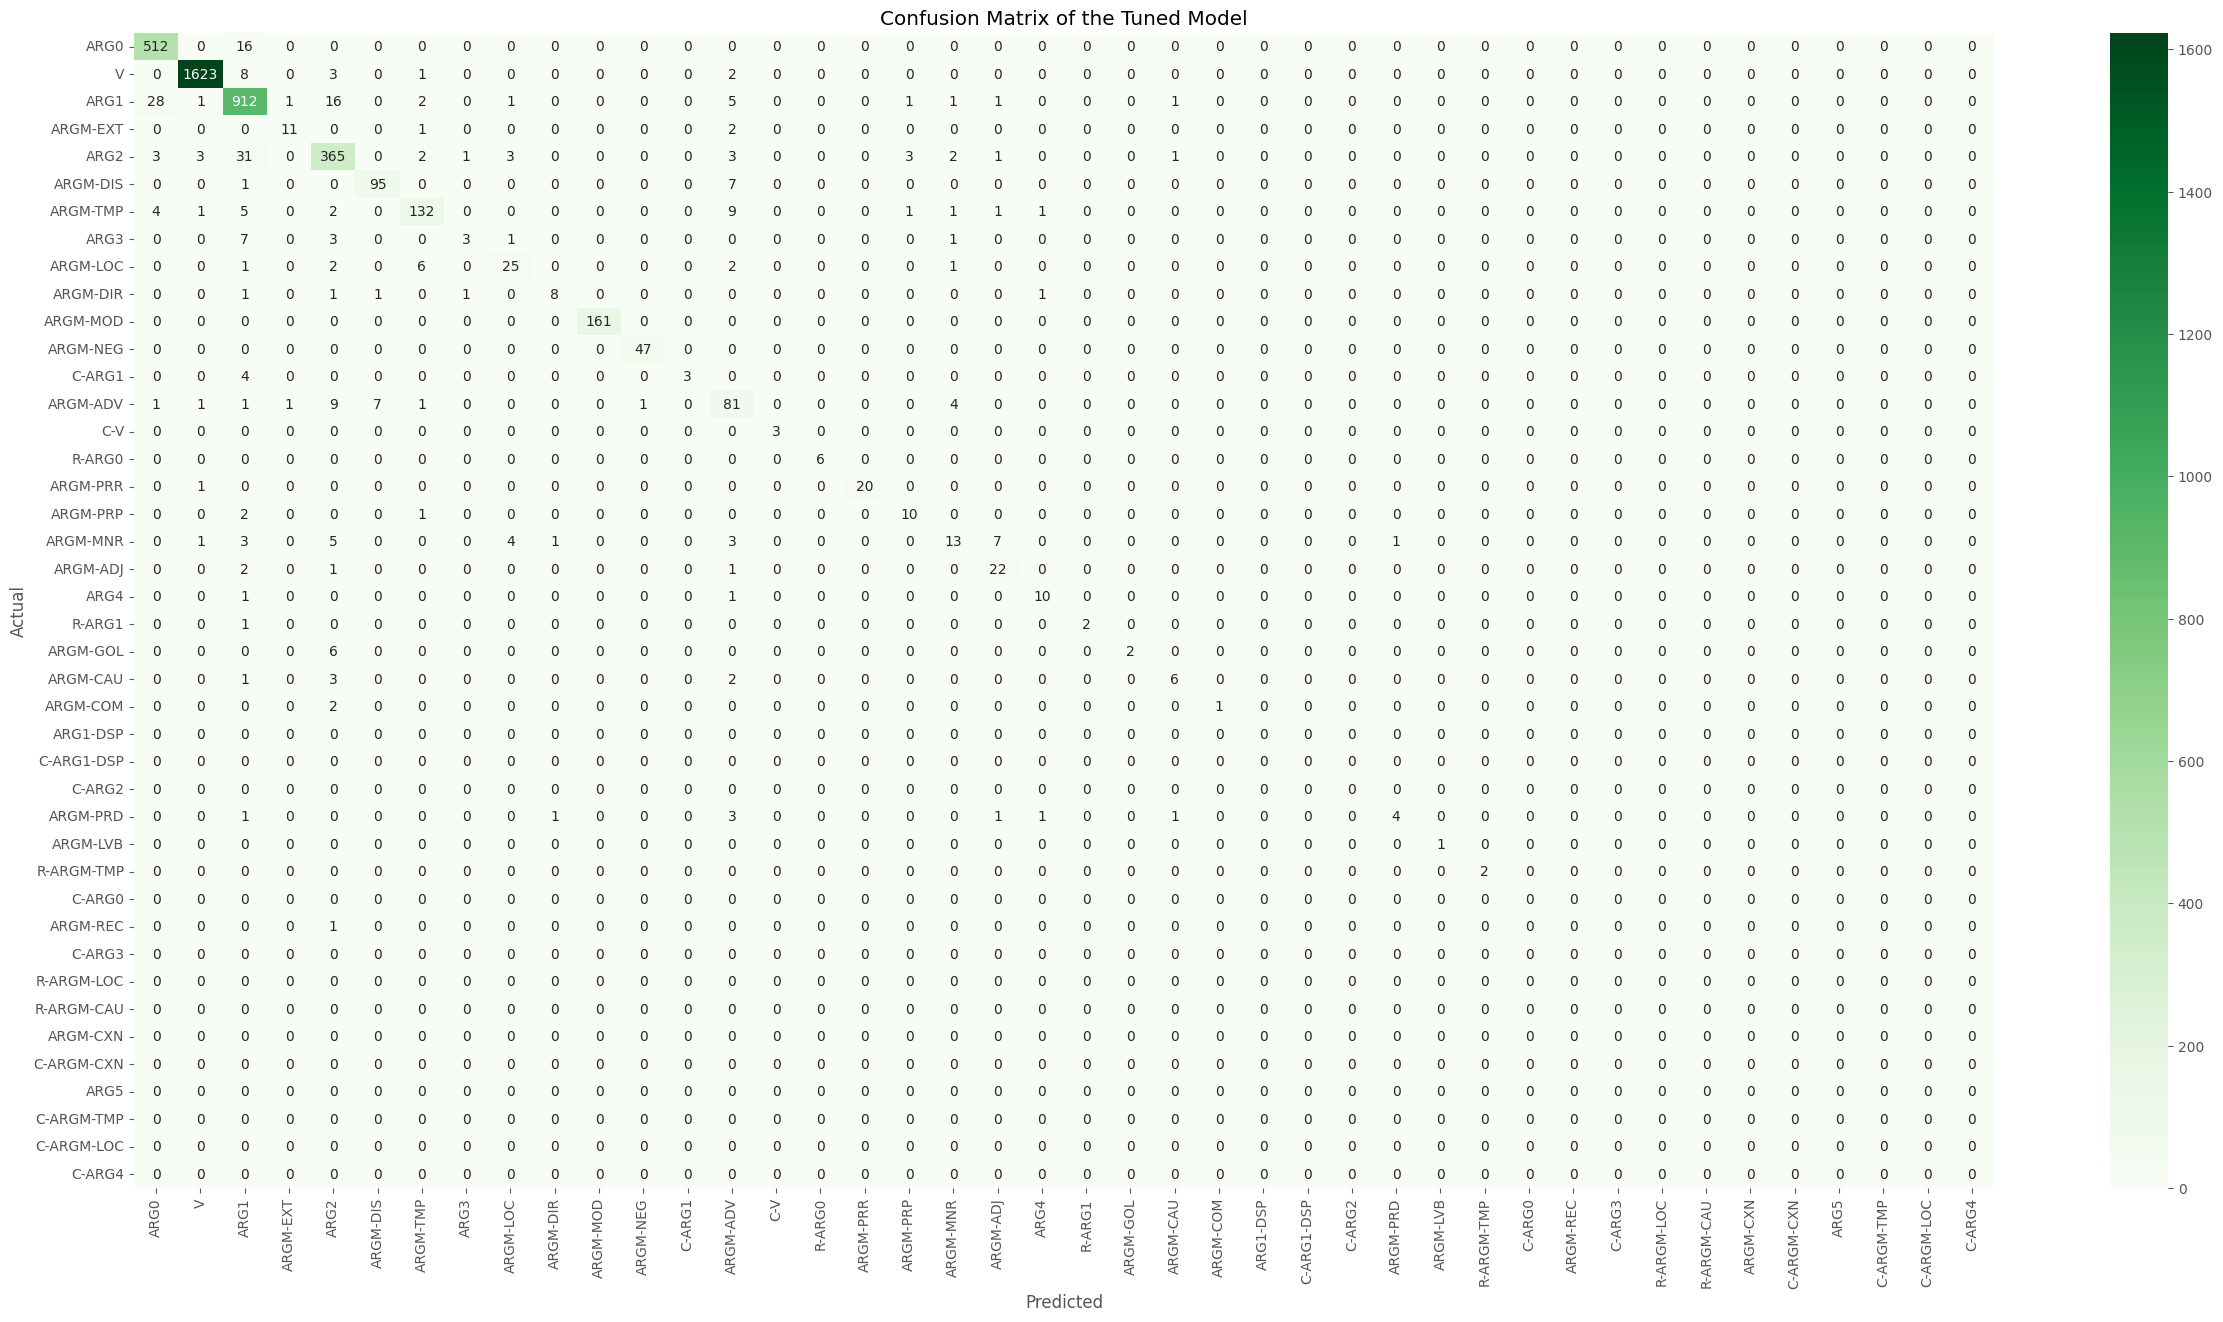

In [19]:
y_val_flat = flatten(y_val)
y_pred_crf_mod_tune_flat = flatten(y_pred_crf_mod_tune)

# Generate the confusion matrix
cm_mod_tune = confusion_matrix(y_val_flat, y_pred_crf_mod_tune_flat, labels=focused_labels)

plt.figure(figsize=(30, 15))
sns.heatmap(cm_mod_tune, annot=True, fmt="d", cmap="Greens", xticklabels=focused_labels, yticklabels=focused_labels)
plt.title('Confusion Matrix of the Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
"""
Investigate Error
"""

# Filter out "_" 
filtered_y_val_mod_tune = [actual for actual, pred in zip(y_val_flat, y_pred_crf_mod_tune_flat) if actual != "_"]
filtered_y_pred_mod_tune = [pred for actual, pred in zip(y_val_flat, y_pred_crf_mod_tune_flat) if actual != "_"]
accuracy_mod_tune = accuracy_score(filtered_y_val_mod_tune, filtered_y_pred_mod_tune)


# Calculate error rate
error_mod_tune = 1 - accuracy_mod_tune
print(f'Baseline Model:')
print(f'Accuracy: {accuracy_mod_tune:.4f}')
print(f'Error Rate: {error_mod_tune:.4f}')


Baseline Model:
Accuracy: 0.7857
Error Rate: 0.2143


In [21]:
"""
**Reintroduce the function in case only run the loaded model
"""

def get_feat_weights(feat_weight, top=20, bottom=30):
    
    # Top
    print('Top features')
    top_features = [f for f in feat_weight[:top] if f[0][1] != '_']  # Exclude "_"
    for feature, weight in top_features:
        print(f"Feature: {feature}, Absolute Weight: {abs(weight)}")

    # Bottom
    print('\nBottom features')
    bottom_features = [f for f in feat_weight[-bottom:] if f[0][1] != '_']
    for feature, weight in bottom_features:
        print(f"Feature: {feature}, Absolute Weight: {abs(weight)}")


feat_weight_mod_tune = crf_model_tune_param.state_features_
feat_weight_mod_tune_sort = sorted(feat_weight_mod_tune.items(), key=lambda x: abs(x[1]), reverse=True)
get_feat_weights(feat_weight_mod_tune_sort)

Top features
Feature: ('word_pred_sense:02', 'V'), Absolute Weight: 10.131806
Feature: ('word_pred_sense:01', 'V'), Absolute Weight: 9.992683
Feature: ('word_pred_sense:LV', 'V'), Absolute Weight: 9.769146
Feature: ('word_pred_sense:03', 'V'), Absolute Weight: 9.231121
Feature: ('word_pred_sense:04', 'V'), Absolute Weight: 8.974487
Feature: ('head_pred_sense:LV', 'ARGM-PRR'), Absolute Weight: 8.95429
Feature: ('word_pred_sense:05', 'V'), Absolute Weight: 8.91821
Feature: ('word_pred_sense:12', 'V'), Absolute Weight: 8.537166
Feature: ('word_lemma:never', 'ARGM-NEG'), Absolute Weight: 8.496312
Feature: ('word_pred_sense:14', 'V'), Absolute Weight: 7.773895
Feature: ('word_pred_sense:07', 'V'), Absolute Weight: 7.686459
Feature: ('word_lemma:not', 'ARGM-NEG'), Absolute Weight: 7.586574
Feature: ('word_pred_sense:06', 'V'), Absolute Weight: 7.409763
Feature: ('word_pred_sense:11', 'V'), Absolute Weight: 6.660469
Feature: ('child_before_1_lemma:because', 'ARGM-CAU'), Absolute Weight: 6.619

<div class="alert alert-block alert-warning"> <h2> 6. Prediction on Test dataset <h3> </div>

This section I reload the save best model and fit the model. Then, use the fit model to generate prediction on the test dataset. The final prediction is generated and saved as CSV file. 

In [21]:
"""
In case of regenerating the prediction without running the prior hyperparameter tuning
"""

# Reload best params
with open('data/best_params_crf_mod_tune.json', 'r') as file:
    best_params_crf_mod_tune_file = json.load(file)

# Fit model
crf_model_final = sklearn_crfsuite.CRF(algorithm='lbfgs', **best_params_crf_mod_tune_file)
crf_model_final.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=False, all_possible_transitions=True,
    c1=0.3370573040630146, c2=0.06640163917149343, max_iterations=200)

In [22]:
# Predict on the test set
y_pred_test = crf_model_final.predict(X_test)
y_pred_test

array([list(['_', '_', 'ARG0', 'V', '_', '_', '_']),
       list(['_', '_', 'ARG0', 'V', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']),
       list(['_', '_', '_', '_', '_', '_', '_', '_', '_']), ...,
       list(['_', '_', 'ARG0', 'V', '_', 'ARG2', '_', '_', '_', '_']),
       list(['ARG0', 'V', '_', '_', 'ARG1', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']),
       list(['ARG0', 'V', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'])],
      dtype=object)

In [23]:
"""
Create dataframe of the predictions.
This dataframe has one less row than the required csv because I dropped the float ID token
"""

all_ids = []
all_tokens = []
all_labels = []

for sentence, labels in zip(test_data, y_pred_test):
    for token_info, label in zip(sentence, labels):
        token_id = token_info[0]   # Get ID
        token_word = token_info[1]   # Get token
        
        all_ids.append(token_id)
        all_tokens.append(token_word)
        all_labels.append(label)

# DataFrame with the ID, token, preds
predictions_df = pd.DataFrame({'ID': all_ids, 'Token': all_tokens, 'Prediction': all_labels})

print(predictions_df.head())
print(predictions_df.shape)

  ID    Token Prediction
0  1     What          _
1  2       if          _
2  3   Google       ARG0
3  4  Morphed          V
4  5     Into          _
(25096, 3)


In [24]:
"""
Use the provided csv to generate final csv file
"""

# Read provided files as string
provided_csv = pd.read_csv('data/provided_csv.csv', sep='\t', header=None, dtype=str)  
provided_csv.columns = ['ID', 'Label']  

# Copy the data from provided csv to the new dataframe
final_df = pd.DataFrame({'ID': provided_csv['ID'], 'Label': provided_csv['Label']})

# Check
print(final_df.head())
print(final_df.shape)

  ID Label
0  1     _
1  2     _
2  3     _
3  4     _
4  5     _
(25097, 2)


In [25]:
"""
Copy the predictions to the final dataframe skipping the float id (retain the _ in float id token)
"""


prediction_index = 0
for i in range(len(final_df)):
    current_id = final_df.loc[i, 'ID']
    
    # Check for non-float IDs 
    if '.' not in str(current_id) and prediction_index < len(predictions_df):
        pred_label = predictions_df.iloc[prediction_index]['Prediction']
        final_df.loc[i, 'Label'] = pred_label
        prediction_index += 1  
    else:
        final_df.loc[i, 'Label'] = '_'  # for float ID token keep the _

# Check 
print(final_df.head(10))
print(final_df.shape)

  ID Label
0  1     _
1  2     _
2  3  ARG0
3  4     V
4  5     _
5  6     _
6  7     _
7  1     _
8  2     _
9  3  ARG0
(25097, 2)


In [26]:
# Save final dataframe to csv
final_df.to_csv('A2_Task_2_pred_labels.csv', sep='\t', index=False, header=False)

<div class="alert alert-block alert-warning"> <h2> 7. Conclusion <h3> </div>

Working on this task, I found that feature design is crucial. The choice of features can impact the model's ability to capture the relationships between tokens. It is also important to understand the syntactic nature of the language, such as what is the predicate token and what its role in the semantics. Hence, in feature design, I aim to capture those relationships as much as possible. Furthermore, using the strength of CRFs and its regularisation, I can utilise the model to inherently prioritise important features. Tuning process also helps ensure that the model perform well with the optimal parameters. Nevertheless, the macro F1 score of 0.4093 is not a huge leap from the baseline. Hence, for future work, I consider experiment with incorporating external embedding features and configuring the feature design.

In conclusion, CRF models can be used to model syntactic and semantic relationship within language. It uses the dependencies between tokens by incorporating wide range of contextual information. However, they require intensive and careful feature engineering, such that understanding of linguistic properties can substantively facilitate this task. Also, it can be computationally expensive given a large dataset or complex language. 